In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 1
EPOCH = 100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "hardtanh"
DIS_ACT = "sigmoid"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adabelief"
GEN_init_lr = 2e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)

    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(discriminator, True)
        dis_optimizer.zero_grad()

        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr.detach())
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        _dis = nn.BCELoss()(y_cls.float(), torch.ones(y_cls.size(), dtype=torch.float, device=device)) + \
                                nn.BCELoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size(), dtype=torch.float, device=device))

        _dis.backward()
        dis_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(discriminator, False)
        gen_optimizer.zero_grad()
        
        # main loss
        # Perceptual loss
        perceptual_loss = PerceptualLoss()(y_pr, y)
        _ssim =SSIMLoss()(y_pr, y, data_range=1.0, size_average=True) # return (N,)
        
        # adversarial loss
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        _gen = nn.BCELoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size(), dtype=torch.float, device=device))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())
        
        _loss = _gen + air_loss + bone_loss + perceptual_loss + _ssim
        _loss.backward()    
        gen_optimizer.step()

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        ssim_l += _ssim.item()
        perceptual_l += perceptual_loss.item()
        
    return  perceptual_l/(index+1), ssim_l/(index+1), air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [13]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    cont_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        acc = Accuracy()(y_cls, torch.ones(y_cls.size(), device=y_cls.device))
        acc_ += [acc.item()]
        acc = Accuracy()(y_pr_cls, torch.zeros(y_pr_cls.size(), device=y_pr_cls.device))
        acc_ += [acc.item()]
        
        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(acc_)/len(acc_)

In [14]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                ct_masked = __ct_masked,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "ct_masked.jpg"), __ct_masked)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1

# Discriminator

In [15]:
from codes.activation import Activation
import torchvision.models as models

In [16]:
class Model(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Model, self).__init__()
        
        encoder = models.densenet161()
        encoder.features[0] = nn.Conv2d(in_channel, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.classifier = nn.Linear(in_features=2208, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Read Data

In [17]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [18]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [19]:
trainset = Dataset(path=train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [20]:
len(trainset), len(testset)

(1344, 191)

In [21]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f52724bf0d0>,)

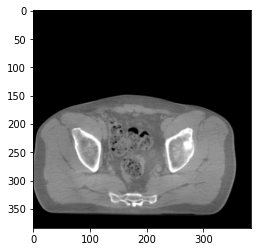

In [22]:
plt.imshow(x.squeeze(), 'gray'),

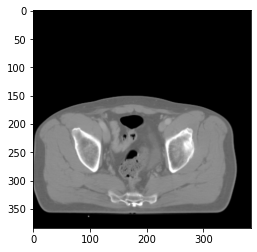

In [23]:
plt.imshow(y.squeeze(), 'gray')

In [24]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [25]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [26]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [27]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [28]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [29]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [30]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_perceptual, loss_ssim, loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_cont_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_cont_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss ssim": loss_ssim,
            "loss perceptual": loss_perceptual,
            "loss mask": loss_air,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "loss bone": loss_bone,
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test + score_cont_test >  max_score:
            max_score = score_bone_test +  score_air_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [05:31,  1.97s/it]
168it [00:41,  4.03it/s]
24it [00:06,  3.85it/s]
168it [05:30,  1.97s/it]
168it [00:41,  4.04it/s]
24it [00:06,  3.82it/s]
168it [05:30,  1.97s/it]
168it [00:41,  4.05it/s]
24it [00:06,  3.85it/s]
168it [05:30,  1.97s/it]
168it [00:41,  4.04it/s]
24it [00:06,  3.86it/s]
168it [05:31,  1.97s/it]
168it [00:41,  4.05it/s]
24it [00:06,  3.86it/s]
168it [05:30,  1.97s/it]
168it [00:41,  4.04it/s]
24it [00:06,  3.86it/s]
168it [05:30,  1.97s/it]
168it [00:41,  4.05it/s]
24it [00:06,  3.85it/s]
168it [05:31,  1.97s/it]
168it [00:41,  4.06it/s]
24it [00:06,  3.84it/s]
168it [05:31,  1.97s/it]
168it [00:41,  4.05it/s]
24it [00:06,  3.87it/s]
168it [05:31,  1.97s/it]
168it [00:41,  4.05it/s]
24it [00:06,  3.83it/s]
168it [05:30,  1.97s/it]
168it [00:41,  4.05it/s]
24it [00:06,  3.86it/s]
168it [05:30,  1.97s/it]
168it [00:41,  4.06it/s]
24it [00:06,  3.85it/s]
168it [05:30,  1.97s/it]
168it [00:41,  4.04it/s]
24it [00:06,  3.84it/s]
168it [05:31,  1.97s/it]
168it [00:41,

In [31]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [32]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [33]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8993555903434753
psnr score = 25.94851303100586
snr score = 16.011451721191406
mae error = 0.01614031009376049
air dice score = 0.9981501161097354
bone dice score = 0.9631249089059448
contour dice score = 0.8119403123855591


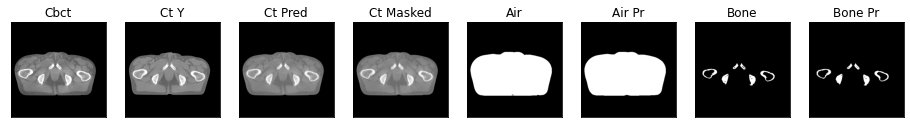

ssim score = 0.9005445837974548
psnr score = 25.928607940673828
snr score = 16.039079666137695
mae error = 0.016155464574694633
air dice score = 0.9978459087019408
bone dice score = 0.9658663581144653
contour dice score = 0.7672052383422852


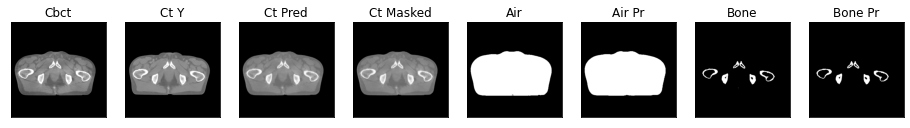

ssim score = 0.8990678787231445
psnr score = 25.916858673095703
snr score = 16.190227508544922
mae error = 0.016618022695183754
air dice score = 0.9976081970924362
bone dice score = 0.9633216317641529
contour dice score = 0.7516457438468933


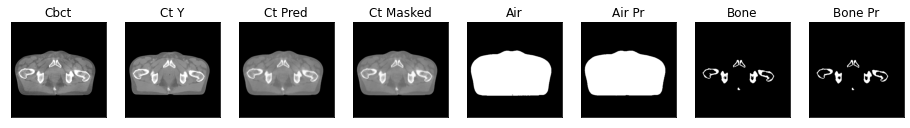

ssim score = 0.8973926305770874
psnr score = 26.107227325439453
snr score = 16.469850540161133
mae error = 0.016472576186060905
air dice score = 0.998086520821417
bone dice score = 0.9554223433247365
contour dice score = 0.8026394844055176


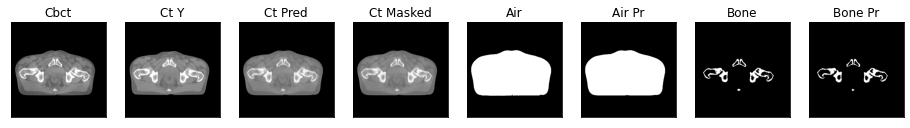

ssim score = 0.896572470664978
psnr score = 26.19839859008789
snr score = 16.601322174072266
mae error = 0.016465017572045326
air dice score = 0.9986349068175536
bone dice score = 0.9471214935006634
contour dice score = 0.8497596383094788


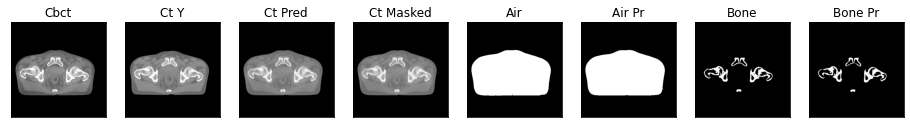

ssim score = 0.8904938697814941
psnr score = 26.1173152923584
snr score = 16.65677261352539
mae error = 0.016917722299695015
air dice score = 0.998867452164757
bone dice score = 0.9513450680840971
contour dice score = 0.8812537789344788


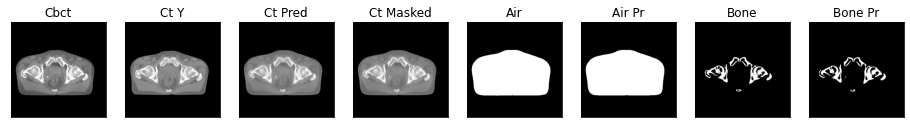

ssim score = 0.8888484835624695
psnr score = 26.181053161621094
snr score = 16.696456909179688
mae error = 0.016931453719735146
air dice score = 0.99852124215659
bone dice score = 0.9576505976414339
contour dice score = 0.8899637460708618


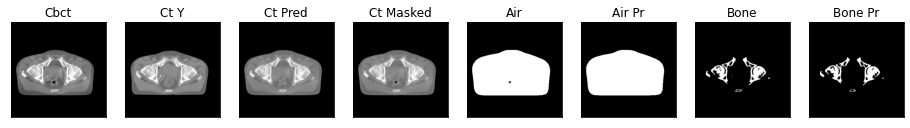

ssim score = 0.8892743587493896
psnr score = 26.36686134338379
snr score = 16.696725845336914
mae error = 0.016314757987856865
air dice score = 0.9985331055963041
bone dice score = 0.9607860338629636
contour dice score = 0.8635536432266235


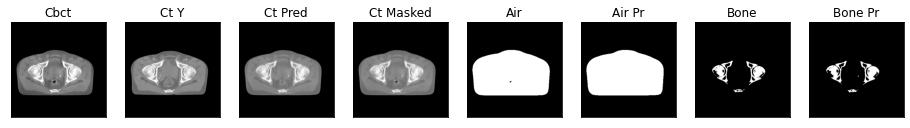

1it [00:03,  3.06s/it]

ssim score = 0.891252338886261
psnr score = 26.545860290527344
snr score = 16.781171798706055
mae error = 0.015839172527194023
air dice score = 0.9987666053339277
bone dice score = 0.965814421143677
contour dice score = 0.8571428656578064


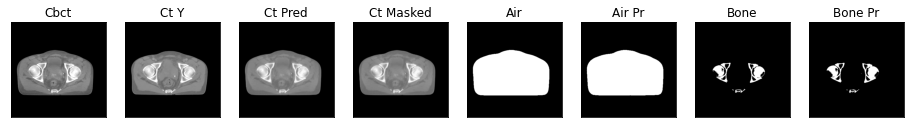

ssim score = 0.8955554366111755
psnr score = 26.76694679260254
snr score = 16.986974716186523
mae error = 0.015421993099153042
air dice score = 0.9982399202368495
bone dice score = 0.9620353806404092
contour dice score = 0.841269850730896


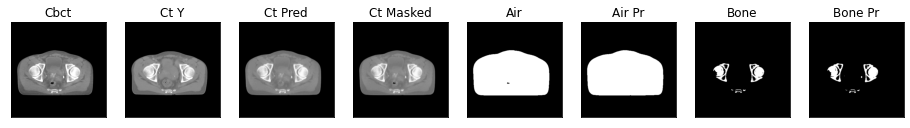

ssim score = 0.9007124304771423
psnr score = 27.076507568359375
snr score = 17.32880210876465
mae error = 0.01484467089176178
air dice score = 0.9984851896583504
bone dice score = 0.9694922411066241
contour dice score = 0.8278388381004333


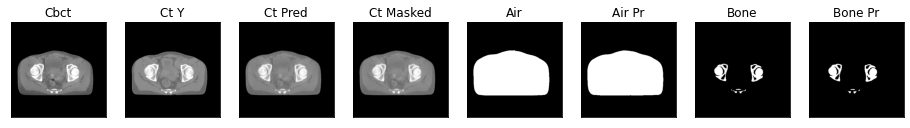

ssim score = 0.9003955125808716
psnr score = 26.968242645263672
snr score = 17.24424934387207
mae error = 0.014985069632530212
air dice score = 0.995922243901436
bone dice score = 0.9755994507238238
contour dice score = 0.8359853029251099


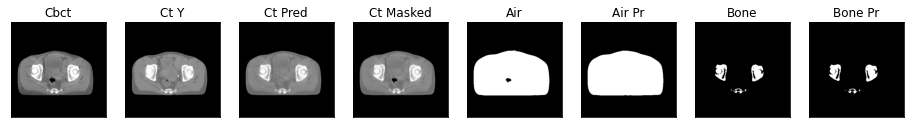

ssim score = 0.9075150489807129
psnr score = 27.317432403564453
snr score = 17.5615177154541
mae error = 0.014525847509503365
air dice score = 0.9932829992189603
bone dice score = 0.9763582632419145
contour dice score = 0.834047794342041


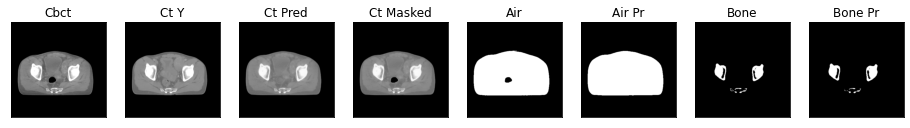

ssim score = 0.9073556065559387
psnr score = 27.340656280517578
snr score = 17.44278335571289
mae error = 0.014402619563043118
air dice score = 0.9915978742621971
bone dice score = 0.964329947981616
contour dice score = 0.7387276291847229


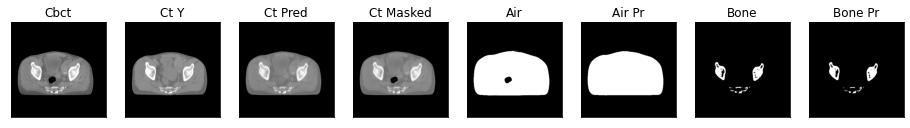

ssim score = 0.9049362540245056
psnr score = 26.942846298217773
snr score = 16.959314346313477
mae error = 0.0147313941270113
air dice score = 0.9933756642824763
bone dice score = 0.9504688944663787
contour dice score = 0.8291178345680237


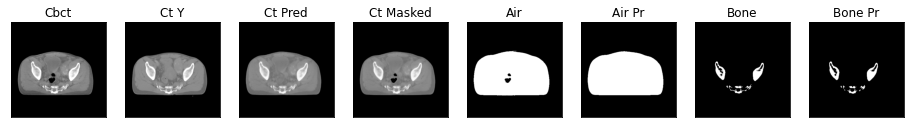

ssim score = 0.8975500464439392
psnr score = 26.12301254272461
snr score = 16.1629638671875
mae error = 0.01594432257115841
air dice score = 0.994405683655243
bone dice score = 0.9663033947141889
contour dice score = 0.8635794520378113


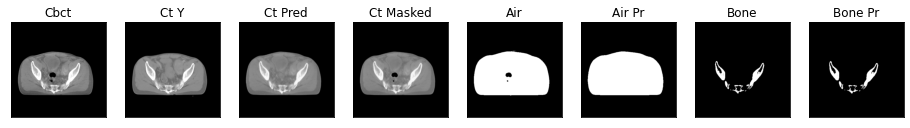

2it [00:05,  2.84s/it]

ssim score = 0.8952528238296509
psnr score = 25.4958438873291
snr score = 15.533252716064453
mae error = 0.016806118190288544
air dice score = 0.9924627971397363
bone dice score = 0.9589171218242826
contour dice score = 0.8867924809455872


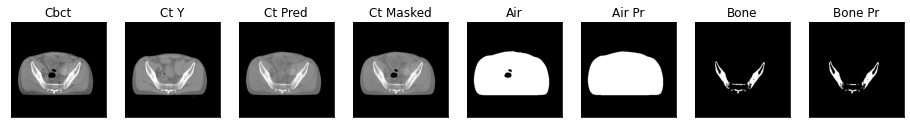

ssim score = 0.8903083801269531
psnr score = 24.97335433959961
snr score = 14.909001350402832
mae error = 0.017538802698254585
air dice score = 0.9903880538789237
bone dice score = 0.9532395720645119
contour dice score = 0.8411910533905029


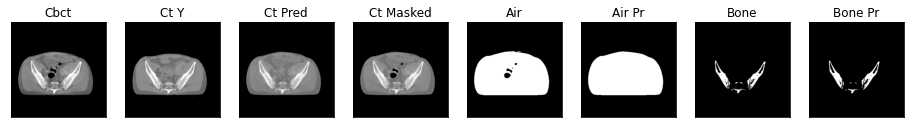

ssim score = 0.8886488676071167
psnr score = 24.46436882019043
snr score = 14.349335670471191
mae error = 0.01821584813296795
air dice score = 0.990824485515805
bone dice score = 0.9480396787913551
contour dice score = 0.8221797347068787


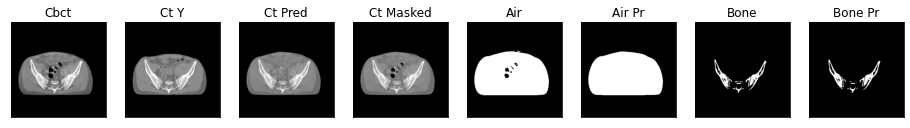

ssim score = 0.8882904648780823
psnr score = 23.984390258789062
snr score = 13.857044219970703
mae error = 0.01902282051742077
air dice score = 0.9924336707160012
bone dice score = 0.9458863858968427
contour dice score = 0.7617236971855164


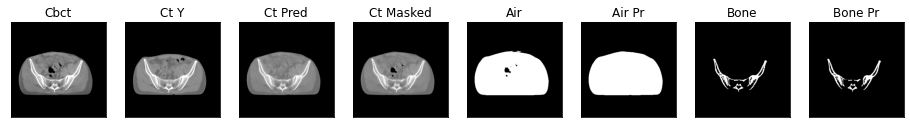

ssim score = 0.8837243914604187
psnr score = 23.551177978515625
snr score = 13.358985900878906
mae error = 0.019811606034636497
air dice score = 0.9927785381268788
bone dice score = 0.9393294305489711
contour dice score = 0.7174887657165527


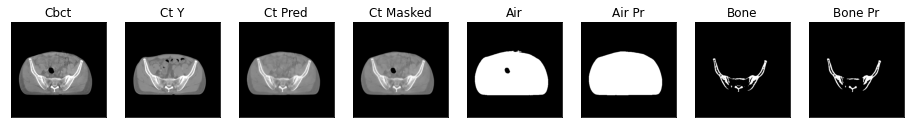

ssim score = 0.8818699717521667
psnr score = 23.251712799072266
snr score = 13.000092506408691
mae error = 0.01996198110282421
air dice score = 0.9936543234835028
bone dice score = 0.9464869815524468
contour dice score = 0.6331399083137512


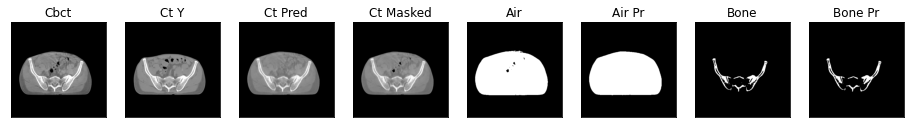

ssim score = 0.8838544487953186
psnr score = 23.166372299194336
snr score = 12.881324768066406
mae error = 0.02014518342912197
air dice score = 0.9953897165697727
bone dice score = 0.954773869347288
contour dice score = 0.7341115474700928


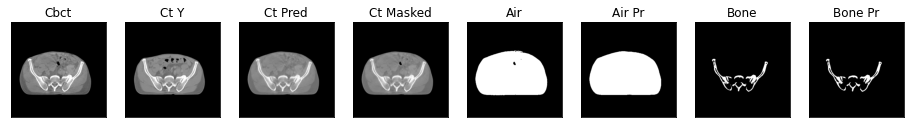

ssim score = 0.8843530416488647
psnr score = 23.005159378051758
snr score = 12.671545028686523
mae error = 0.02072635479271412
air dice score = 0.9962931934769429
bone dice score = 0.9456534665246086
contour dice score = 0.737260103225708


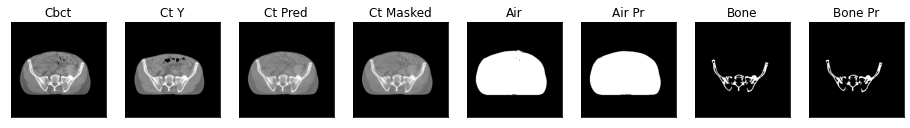

3it [00:07,  2.74s/it]

ssim score = 0.8842471241950989
psnr score = 22.91181182861328
snr score = 12.48119831085205
mae error = 0.02105756849050522
air dice score = 0.9956907595909765
bone dice score = 0.9495271732944113
contour dice score = 0.6425217986106873


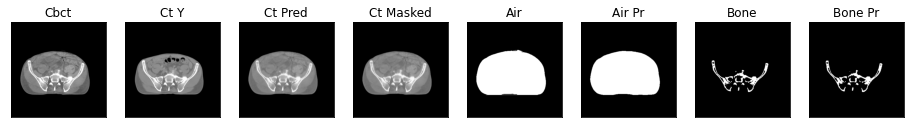

ssim score = 0.88824063539505
psnr score = 23.178050994873047
snr score = 12.664700508117676
mae error = 0.020292416214942932
air dice score = 0.9961916549639442
bone dice score = 0.9431134324975234
contour dice score = 0.7700680494308472


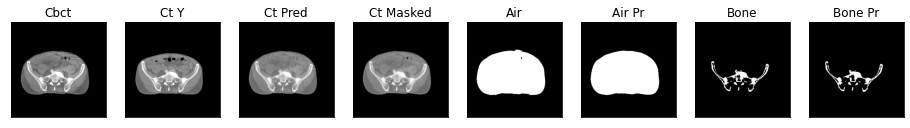

ssim score = 0.8861079812049866
psnr score = 23.231136322021484
snr score = 12.626602172851562
mae error = 0.020597245544195175
air dice score = 0.9953239812959309
bone dice score = 0.9515555555560938
contour dice score = 0.7364016771316528


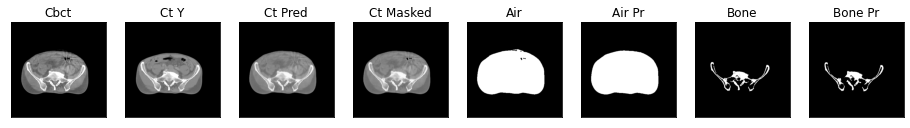

ssim score = 0.8874268531799316
psnr score = 23.20806312561035
snr score = 12.562422752380371
mae error = 0.020555967465043068
air dice score = 0.994238298081902
bone dice score = 0.9515651438245393
contour dice score = 0.7325335144996643


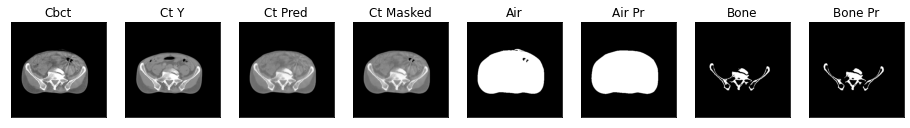

ssim score = 0.8704261779785156
psnr score = 23.44940185546875
snr score = 14.821558952331543
mae error = 0.025070037692785263
air dice score = 0.9959838366390105
bone dice score = 0.9810006333128245
contour dice score = 0.6739130616188049


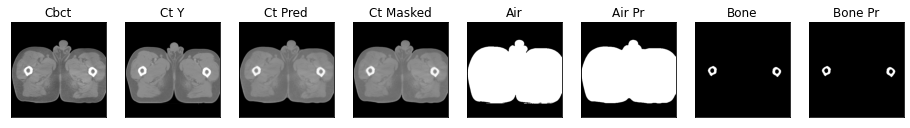

ssim score = 0.8795034885406494
psnr score = 24.115076065063477
snr score = 15.526494026184082
mae error = 0.023790011182427406
air dice score = 0.995941320293401
bone dice score = 0.9819259259264614
contour dice score = 0.6638261675834656


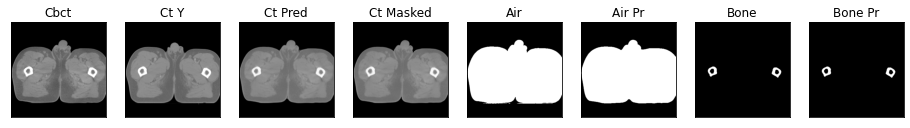

ssim score = 0.8854287266731262
psnr score = 24.67267608642578
snr score = 16.171539306640625
mae error = 0.022906934842467308
air dice score = 0.9964949367934464
bone dice score = 0.9733679000713323
contour dice score = 0.6785237789154053


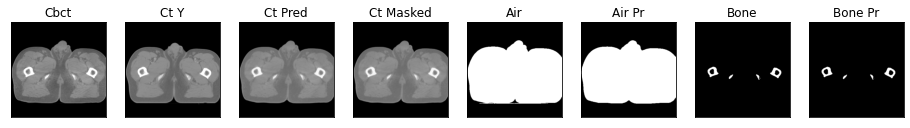

ssim score = 0.891326904296875
psnr score = 25.099323272705078
snr score = 16.760744094848633
mae error = 0.022188454866409302
air dice score = 0.997904424864272
bone dice score = 0.9699296225212743
contour dice score = 0.7762976288795471


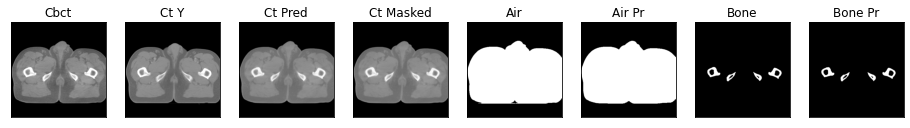

4it [00:10,  2.61s/it]

ssim score = 0.8928189873695374
psnr score = 25.37902069091797
snr score = 17.168582916259766
mae error = 0.021707022562623024
air dice score = 0.998208359386274
bone dice score = 0.9694286899990395
contour dice score = 0.7884972095489502


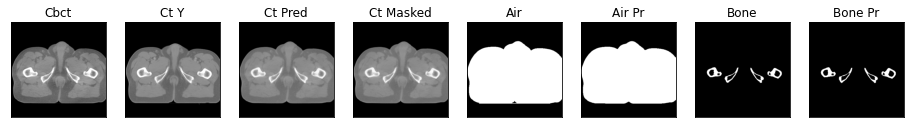

ssim score = 0.895529568195343
psnr score = 25.855924606323242
snr score = 17.74872589111328
mae error = 0.021100882440805435
air dice score = 0.9983470084446318
bone dice score = 0.9653596343521125
contour dice score = 0.810009241104126


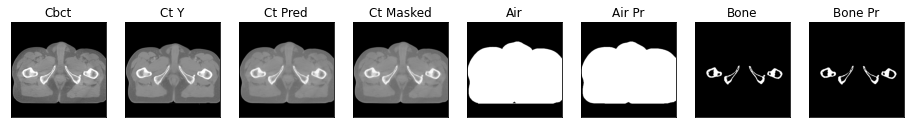

ssim score = 0.8964005708694458
psnr score = 26.20136260986328
snr score = 18.161264419555664
mae error = 0.02109057828783989
air dice score = 0.9983417043461672
bone dice score = 0.9619529360021778
contour dice score = 0.7840592861175537


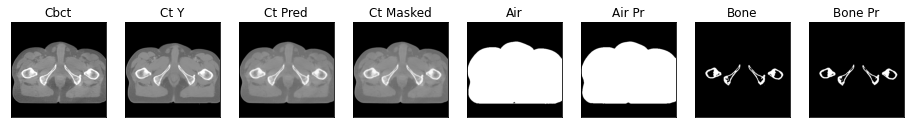

ssim score = 0.8954580426216125
psnr score = 26.190826416015625
snr score = 18.140838623046875
mae error = 0.02147248387336731
air dice score = 0.9983286642994378
bone dice score = 0.9682523160198996
contour dice score = 0.7796766757965088


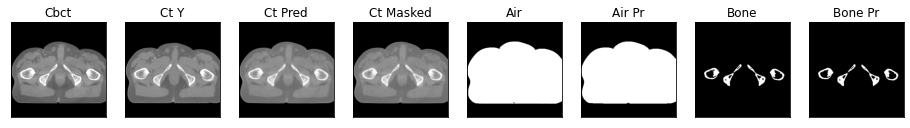

ssim score = 0.8986941576004028
psnr score = 26.273635864257812
snr score = 18.209983825683594
mae error = 0.02132364548742771
air dice score = 0.9984509742244494
bone dice score = 0.968438367431187
contour dice score = 0.790397047996521


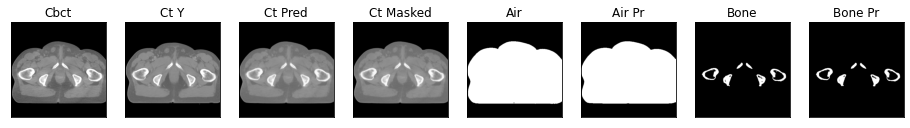

ssim score = 0.8977600336074829
psnr score = 26.31099510192871
snr score = 18.259342193603516
mae error = 0.021585512906312943
air dice score = 0.9985240683551966
bone dice score = 0.966409392325618
contour dice score = 0.7892791032791138


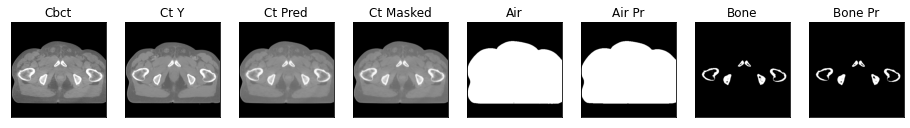

ssim score = 0.8991150259971619
psnr score = 26.399456024169922
snr score = 18.386890411376953
mae error = 0.02129696123301983
air dice score = 0.9985602303631428
bone dice score = 0.9668533034718158
contour dice score = 0.8146432042121887


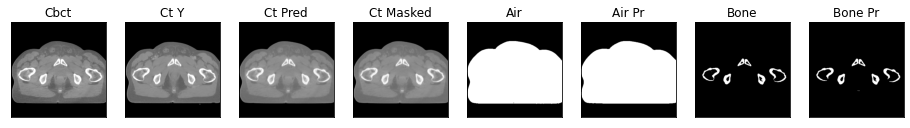

ssim score = 0.8961178660392761
psnr score = 26.442646026611328
snr score = 18.57137107849121
mae error = 0.021310115233063698
air dice score = 0.9986192838053257
bone dice score = 0.9645890999335249
contour dice score = 0.822708249092102


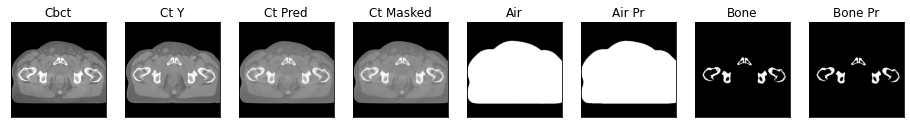

5it [00:12,  2.59s/it]

ssim score = 0.896689236164093
psnr score = 26.540109634399414
snr score = 18.763519287109375
mae error = 0.021293342113494873
air dice score = 0.9989674080755816
bone dice score = 0.9662210268177658
contour dice score = 0.8474102020263672


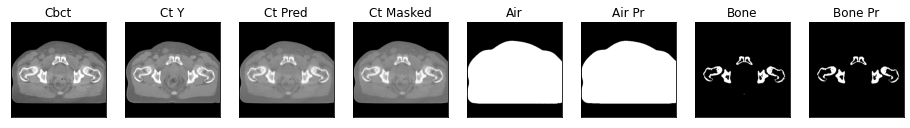

ssim score = 0.888332188129425
psnr score = 26.088293075561523
snr score = 18.277658462524414
mae error = 0.022716626524925232
air dice score = 0.998529875664384
bone dice score = 0.9514473176383524
contour dice score = 0.8398876190185547


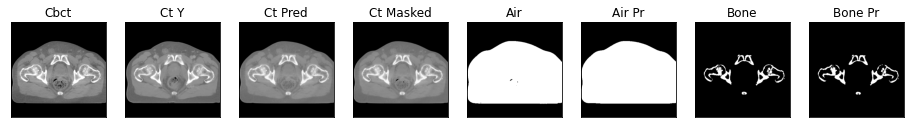

ssim score = 0.8905200362205505
psnr score = 26.21767234802246
snr score = 18.47922134399414
mae error = 0.02244342304766178
air dice score = 0.9969749145084553
bone dice score = 0.9532943572229304
contour dice score = 0.8134957551956177


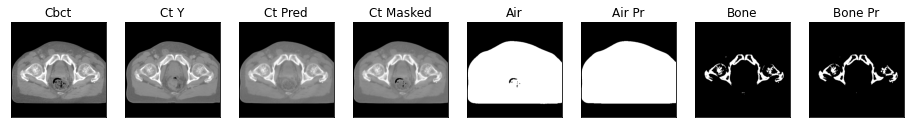

ssim score = 0.8872036337852478
psnr score = 26.006851196289062
snr score = 18.132305145263672
mae error = 0.022366322576999664
air dice score = 0.9971980056039905
bone dice score = 0.9423804609568078
contour dice score = 0.8332550525665283


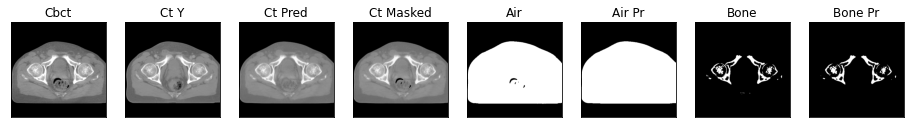

ssim score = 0.8897156119346619
psnr score = 25.742389678955078
snr score = 17.68928337097168
mae error = 0.022232718765735626
air dice score = 0.9974781671872852
bone dice score = 0.9422798027657132
contour dice score = 0.8385269045829773


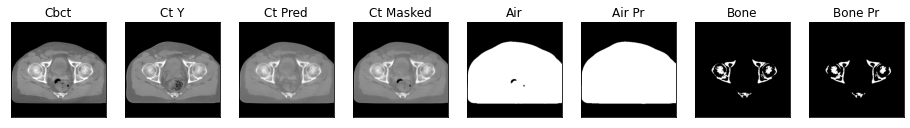

ssim score = 0.8845644593238831
psnr score = 25.288236618041992
snr score = 17.144542694091797
mae error = 0.023239631205797195
air dice score = 0.998654023744712
bone dice score = 0.9320216646409636
contour dice score = 0.8410061597824097


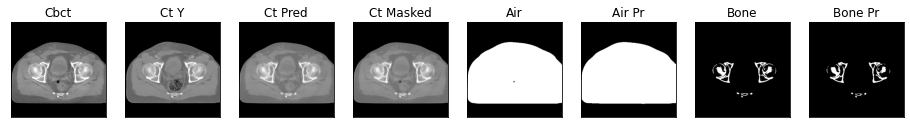

ssim score = 0.8833423852920532
psnr score = 25.207000732421875
snr score = 17.078994750976562
mae error = 0.022943146526813507
air dice score = 0.998896220464801
bone dice score = 0.9415365779008108
contour dice score = 0.8427553176879883


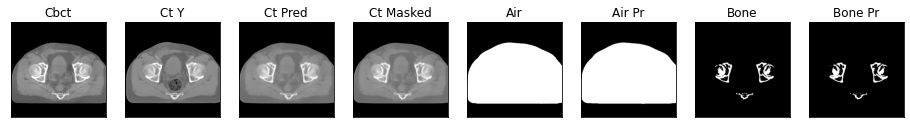

ssim score = 0.8719464540481567
psnr score = 24.98784065246582
snr score = 16.869873046875
mae error = 0.024056212976574898
air dice score = 0.9987686080394053
bone dice score = 0.9501594533034154
contour dice score = 0.8396002054214478


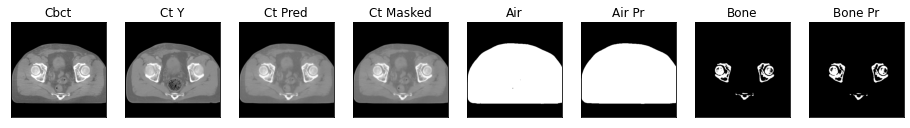

6it [00:15,  2.58s/it]

ssim score = 0.880643904209137
psnr score = 25.45659637451172
snr score = 17.400217056274414
mae error = 0.023193487897515297
air dice score = 0.9986543848703936
bone dice score = 0.9676392572947158
contour dice score = 0.8269962072372437


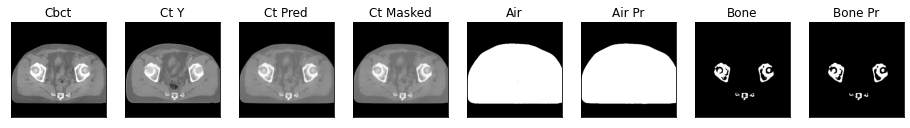

ssim score = 0.882290244102478
psnr score = 26.150386810302734
snr score = 18.16408920288086
mae error = 0.02169039472937584
air dice score = 0.9984857680589027
bone dice score = 0.973057264143004
contour dice score = 0.8106312155723572


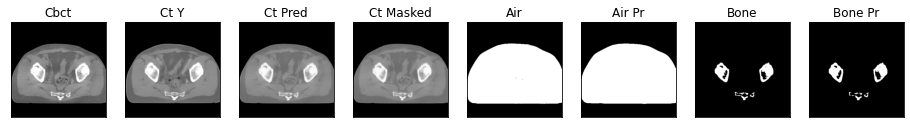

ssim score = 0.8860476613044739
psnr score = 25.457672119140625
snr score = 17.352270126342773
mae error = 0.023260409012436867
air dice score = 0.9984796655264168
bone dice score = 0.9687832221903084
contour dice score = 0.8043684959411621


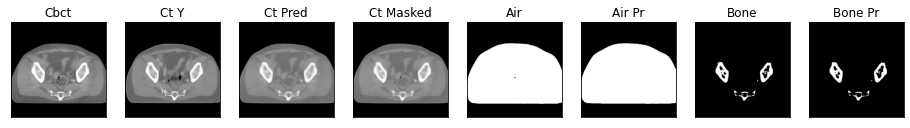

ssim score = 0.879187285900116
psnr score = 24.92771339416504
snr score = 16.90393829345703
mae error = 0.024886051192879677
air dice score = 0.9978083332313018
bone dice score = 0.9726153588478971
contour dice score = 0.8120229244232178


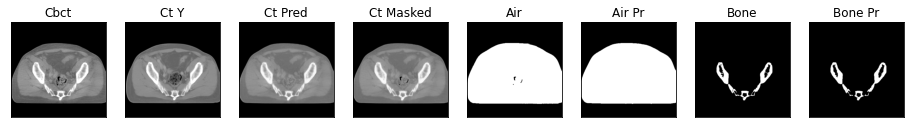

ssim score = 0.8811350464820862
psnr score = 25.035533905029297
snr score = 17.09190559387207
mae error = 0.024663230404257774
air dice score = 0.9967775010985811
bone dice score = 0.9725129063766393
contour dice score = 0.7783628702163696


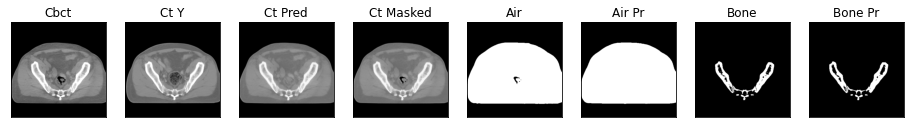

ssim score = 0.8654255270957947
psnr score = 24.878385543823242
snr score = 16.95631217956543
mae error = 0.026013782247900963
air dice score = 0.9961231110056199
bone dice score = 0.9628954197940458
contour dice score = 0.773666501045227


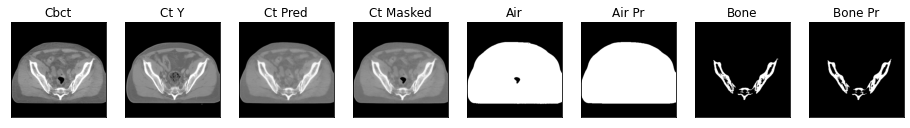

ssim score = 0.8642432689666748
psnr score = 25.02558135986328
snr score = 17.11604881286621
mae error = 0.025741036981344223
air dice score = 0.9982095980063642
bone dice score = 0.9686853555890671
contour dice score = 0.7631831169128418


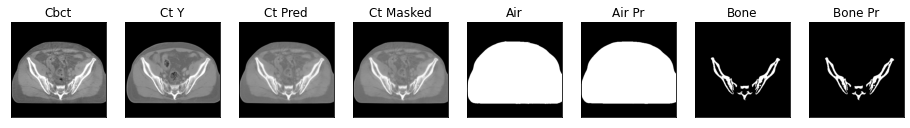

ssim score = 0.8123447299003601
psnr score = 21.096576690673828
snr score = 10.976785659790039
mae error = 0.03163490816950798
air dice score = 0.9979373342500755
bone dice score = 0.9691799669793841
contour dice score = 0.7747647762298584


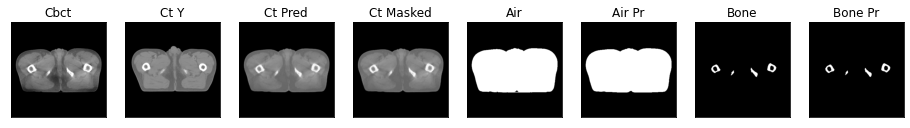

7it [00:17,  2.50s/it]

ssim score = 0.8016337752342224
psnr score = 20.763704299926758
snr score = 10.856894493103027
mae error = 0.03380119800567627
air dice score = 0.9980555974820449
bone dice score = 0.9530380592042502
contour dice score = 0.800000011920929


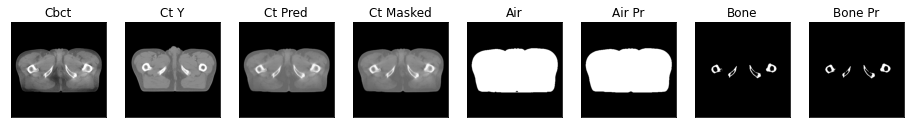

ssim score = 0.7974722385406494
psnr score = 20.784608840942383
snr score = 11.008935928344727
mae error = 0.03412053734064102
air dice score = 0.9979427683451223
bone dice score = 0.9315185027662374
contour dice score = 0.7819879055023193


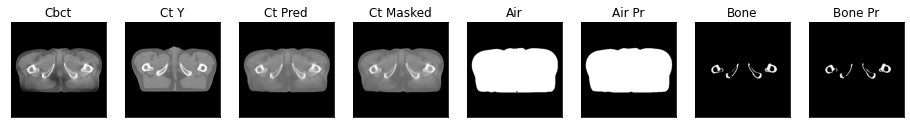

ssim score = 0.8024630546569824
psnr score = 21.128887176513672
snr score = 11.423616409301758
mae error = 0.032754745334386826
air dice score = 0.9971334611258664
bone dice score = 0.940413457642067
contour dice score = 0.7484931349754333


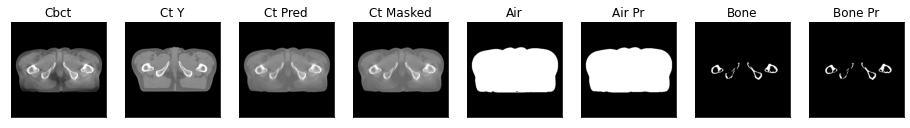

ssim score = 0.8049085140228271
psnr score = 21.24689292907715
snr score = 11.589189529418945
mae error = 0.03247779235243797
air dice score = 0.9963696311755762
bone dice score = 0.9337539432189718
contour dice score = 0.671389639377594


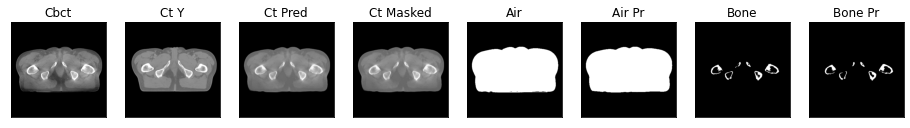

ssim score = 0.8050098419189453
psnr score = 21.405611038208008
snr score = 11.753522872924805
mae error = 0.03189347684383392
air dice score = 0.9959880077268034
bone dice score = 0.9429933269791613
contour dice score = 0.6985138058662415


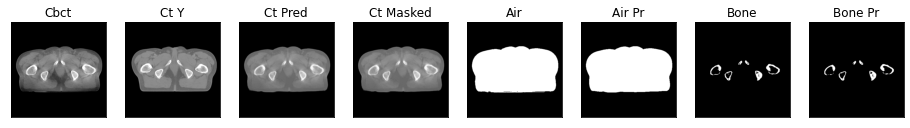

ssim score = 0.8084279298782349
psnr score = 21.49427604675293
snr score = 11.835684776306152
mae error = 0.03136827051639557
air dice score = 0.9953719440449772
bone dice score = 0.9464767038901333
contour dice score = 0.6634717583656311


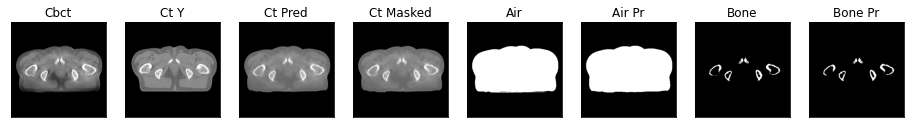

ssim score = 0.8064869046211243
psnr score = 21.330379486083984
snr score = 11.685900688171387
mae error = 0.031790316104888916
air dice score = 0.9961191515961868
bone dice score = 0.9454477050424107
contour dice score = 0.7056323289871216


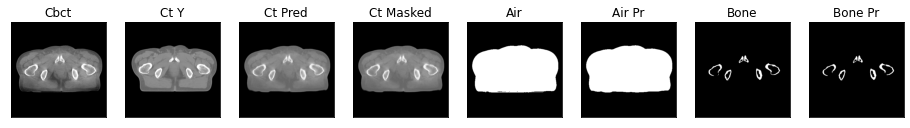

ssim score = 0.8055815696716309
psnr score = 21.234317779541016
snr score = 11.647844314575195
mae error = 0.03246542811393738
air dice score = 0.9963498270286236
bone dice score = 0.9347972972983987
contour dice score = 0.6745055913925171


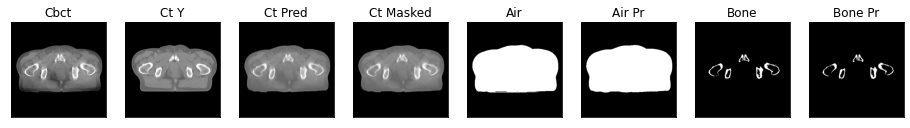

8it [00:20,  2.50s/it]

ssim score = 0.797839879989624
psnr score = 21.06098175048828
snr score = 11.573066711425781
mae error = 0.03406237065792084
air dice score = 0.9960410075549366
bone dice score = 0.9152707757372699
contour dice score = 0.6680760979652405


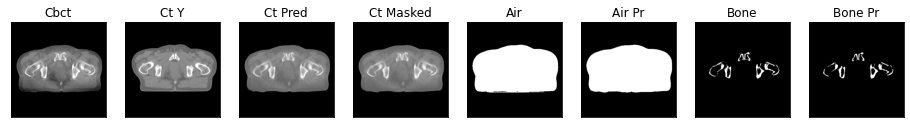

ssim score = 0.7866785526275635
psnr score = 20.889366149902344
snr score = 11.437280654907227
mae error = 0.035336341708898544
air dice score = 0.9965234944488086
bone dice score = 0.919618109024952
contour dice score = 0.6953250765800476


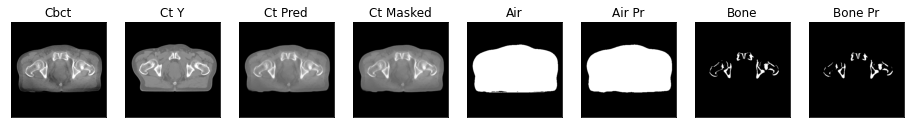

ssim score = 0.7756963968276978
psnr score = 20.76421356201172
snr score = 11.344834327697754
mae error = 0.035792604088783264
air dice score = 0.9968549936669078
bone dice score = 0.9065101678735292
contour dice score = 0.7070165872573853


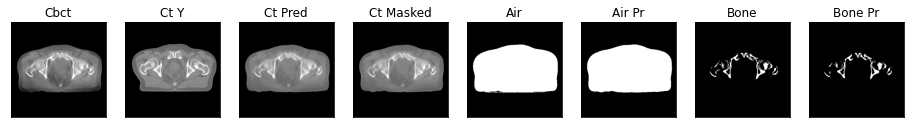

ssim score = 0.7762085795402527
psnr score = 20.825021743774414
snr score = 11.5224609375
mae error = 0.03592844307422638
air dice score = 0.9974506493953927
bone dice score = 0.9235790046243734
contour dice score = 0.76752769947052


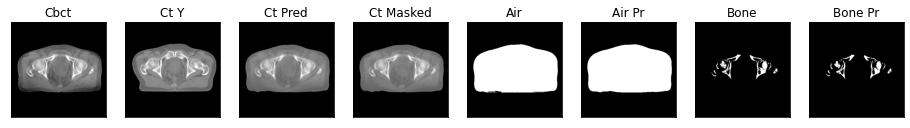

ssim score = 0.7797221541404724
psnr score = 20.792943954467773
snr score = 11.474394798278809
mae error = 0.03595335781574249
air dice score = 0.9977010702508178
bone dice score = 0.9060351413306946
contour dice score = 0.7664670944213867


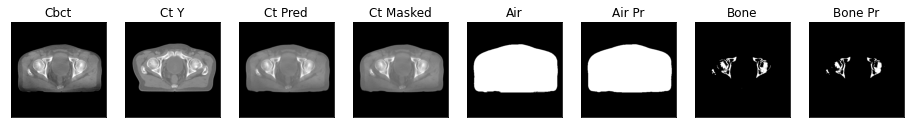

ssim score = 0.794188380241394
psnr score = 21.321928024291992
snr score = 11.804218292236328
mae error = 0.03268957510590553
air dice score = 0.997436426826333
bone dice score = 0.9277147487856124
contour dice score = 0.7332260012626648


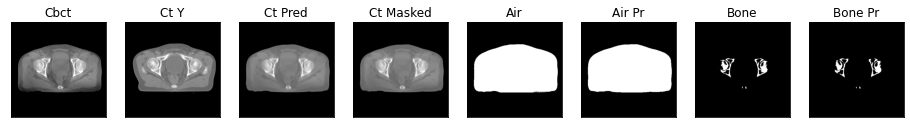

ssim score = 0.8110840916633606
psnr score = 22.021373748779297
snr score = 12.333269119262695
mae error = 0.029586898162961006
air dice score = 0.9973207385143862
bone dice score = 0.9486993169604898
contour dice score = 0.7233584523200989


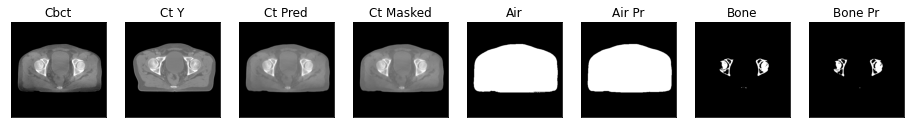

ssim score = 0.8178849220275879
psnr score = 22.396251678466797
snr score = 12.722315788269043
mae error = 0.028494199737906456
air dice score = 0.9972564216879889
bone dice score = 0.9593691526335288
contour dice score = 0.7289220690727234


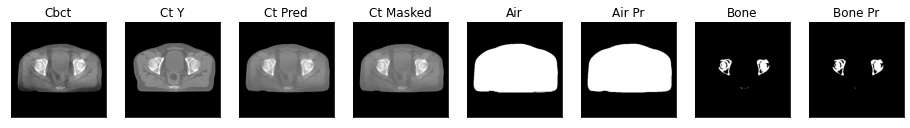

9it [00:22,  2.50s/it]

ssim score = 0.8215804696083069
psnr score = 22.577537536621094
snr score = 12.985431671142578
mae error = 0.028340164572000504
air dice score = 0.9970992666877757
bone dice score = 0.9671159029654027
contour dice score = 0.7162235379219055


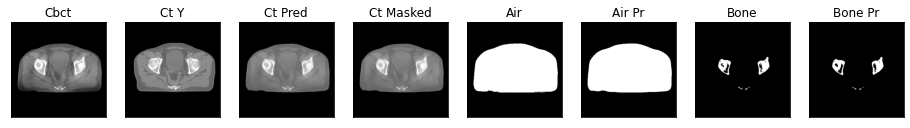

ssim score = 0.8213539123535156
psnr score = 22.525440216064453
snr score = 13.025505065917969
mae error = 0.028868257999420166
air dice score = 0.9970563391097371
bone dice score = 0.9600856400067276
contour dice score = 0.7271727323532104


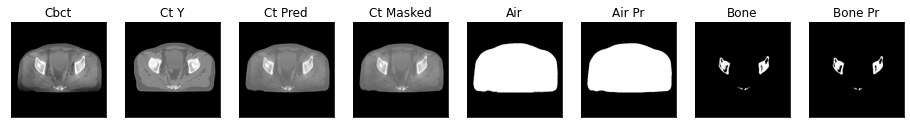

ssim score = 0.8167239427566528
psnr score = 22.781700134277344
snr score = 13.218338012695312
mae error = 0.028028704226017
air dice score = 0.9972125435540093
bone dice score = 0.9670255720059383
contour dice score = 0.7156652212142944


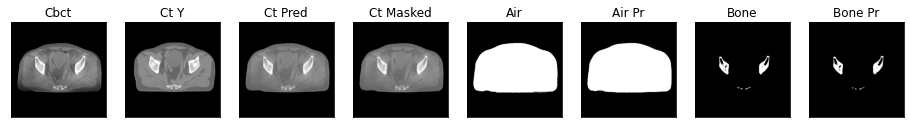

ssim score = 0.8228604793548584
psnr score = 23.165809631347656
snr score = 13.566054344177246
mae error = 0.02657506614923477
air dice score = 0.9959534090619918
bone dice score = 0.9684554024661266
contour dice score = 0.7021276354789734


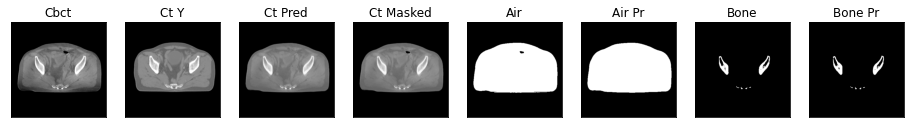

ssim score = 0.8203347325325012
psnr score = 23.041675567626953
snr score = 13.479665756225586
mae error = 0.027751678600907326
air dice score = 0.996081358462403
bone dice score = 0.9502186343768884
contour dice score = 0.739130437374115


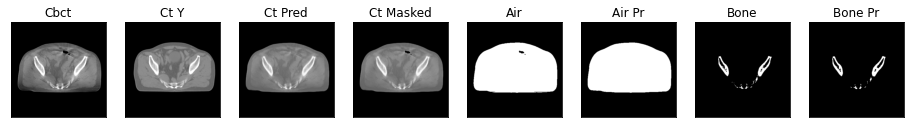

ssim score = 0.8160309791564941
psnr score = 22.89764404296875
snr score = 13.466140747070312
mae error = 0.028608402237296104
air dice score = 0.9966796029110824
bone dice score = 0.9507482202535124
contour dice score = 0.7645488381385803


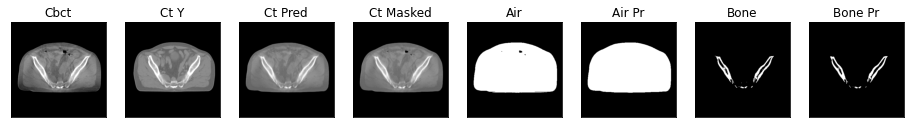

ssim score = 0.817950963973999
psnr score = 22.851512908935547
snr score = 13.437756538391113
mae error = 0.02885032631456852
air dice score = 0.9964540216168328
bone dice score = 0.9364453556231439
contour dice score = 0.7443609237670898


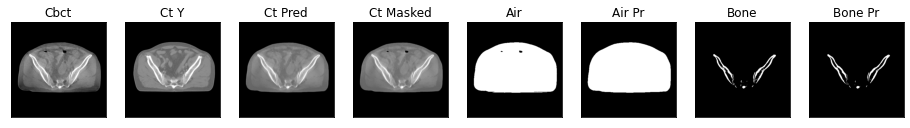

ssim score = 0.8200214505195618
psnr score = 23.158580780029297
snr score = 13.73355770111084
mae error = 0.027923226356506348
air dice score = 0.9973270278605965
bone dice score = 0.9389379000183543
contour dice score = 0.7486515641212463


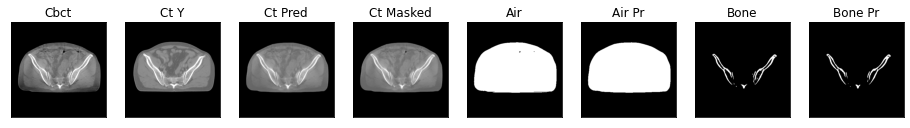

10it [00:24,  2.44s/it]

ssim score = 0.8231866955757141
psnr score = 23.21774673461914
snr score = 13.79198169708252
mae error = 0.027492130175232887
air dice score = 0.9975919364271237
bone dice score = 0.9251400441363922
contour dice score = 0.7697332501411438


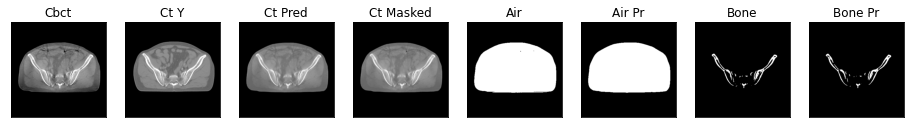

ssim score = 0.8812872171401978
psnr score = 24.374303817749023
snr score = 14.808440208435059
mae error = 0.02047366090118885
air dice score = 0.9970816269730849
bone dice score = 0.9666924864459066
contour dice score = 0.742521345615387


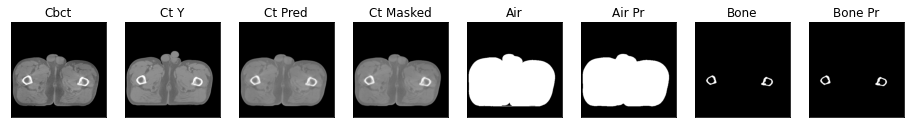

ssim score = 0.8796075582504272
psnr score = 24.601469039916992
snr score = 15.099997520446777
mae error = 0.020266812294721603
air dice score = 0.9969023611594044
bone dice score = 0.9557835160963642
contour dice score = 0.6976743936538696


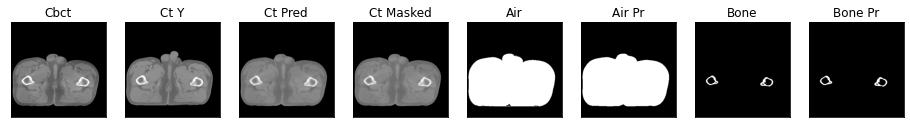

ssim score = 0.8865364789962769
psnr score = 26.30316162109375
snr score = 16.940898895263672
mae error = 0.01856701634824276
air dice score = 0.996961578417055
bone dice score = 0.9580371474442092
contour dice score = 0.7107692360877991


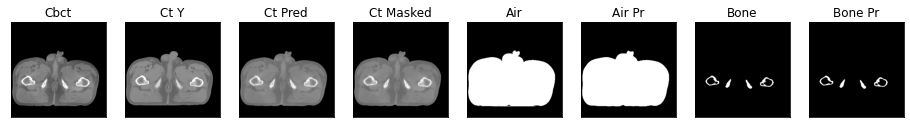

ssim score = 0.8872871994972229
psnr score = 26.164072036743164
snr score = 16.923301696777344
mae error = 0.018821993842720985
air dice score = 0.9976689976689995
bone dice score = 0.9489342806405654
contour dice score = 0.7670807242393494


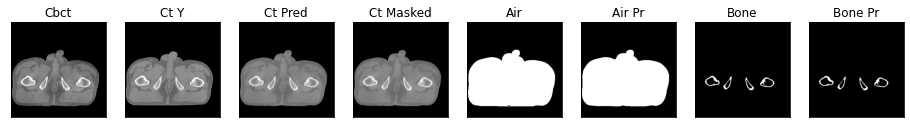

ssim score = 0.8832833766937256
psnr score = 25.91374969482422
snr score = 16.69715118408203
mae error = 0.01894613914191723
air dice score = 0.9977834612105729
bone dice score = 0.9375873311612113
contour dice score = 0.7441375851631165


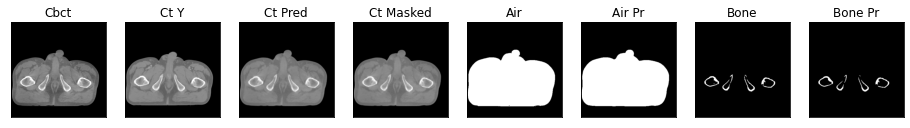

ssim score = 0.8841326236724854
psnr score = 25.710315704345703
snr score = 16.489322662353516
mae error = 0.01902681402862072
air dice score = 0.9980719943631015
bone dice score = 0.9318662716899732
contour dice score = 0.773822009563446


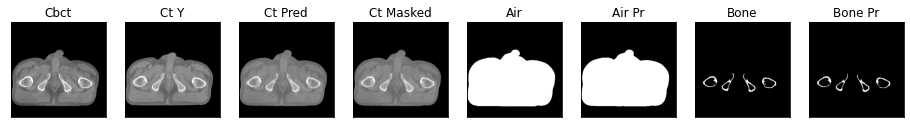

ssim score = 0.883735716342926
psnr score = 25.14946746826172
snr score = 15.93472957611084
mae error = 0.01996459625661373
air dice score = 0.9980965645311064
bone dice score = 0.9276910435511978
contour dice score = 0.7669647336006165


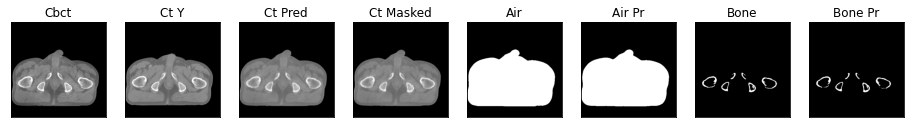

11it [00:27,  2.47s/it]

ssim score = 0.8817446827888489
psnr score = 24.830284118652344
snr score = 15.593987464904785
mae error = 0.020135970786213875
air dice score = 0.9982024700540822
bone dice score = 0.9348268839117143
contour dice score = 0.7770163416862488


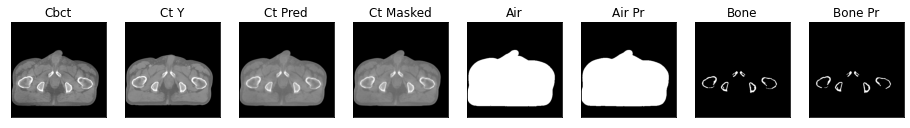

ssim score = 0.8825108408927917
psnr score = 24.89025115966797
snr score = 15.670866012573242
mae error = 0.020116237923502922
air dice score = 0.9981739204761808
bone dice score = 0.9419404125297567
contour dice score = 0.7661375403404236


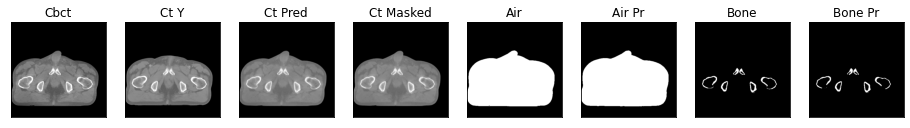

ssim score = 0.8835304975509644
psnr score = 25.288631439208984
snr score = 16.137840270996094
mae error = 0.019459351897239685
air dice score = 0.9981353618100268
bone dice score = 0.943474503026042
contour dice score = 0.7848775386810303


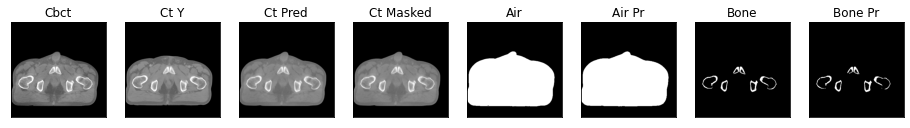

ssim score = 0.8848240375518799
psnr score = 25.790267944335938
snr score = 16.720834732055664
mae error = 0.018836067989468575
air dice score = 0.9984094025465242
bone dice score = 0.940414098309777
contour dice score = 0.8182305693626404


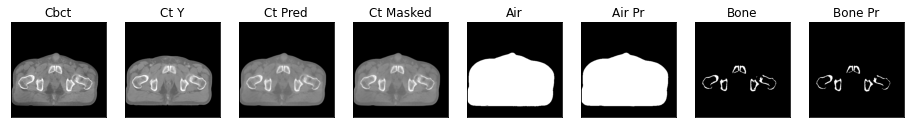

ssim score = 0.8863257169723511
psnr score = 26.405834197998047
snr score = 17.38710594177246
mae error = 0.018290815874934196
air dice score = 0.9984349070775245
bone dice score = 0.9181818181830579
contour dice score = 0.8444206118583679


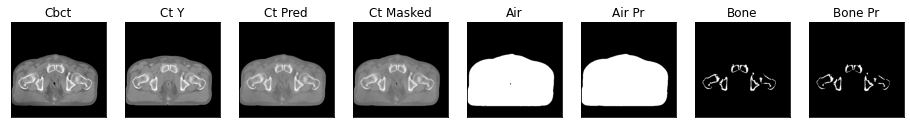

ssim score = 0.8888252973556519
psnr score = 26.91803741455078
snr score = 18.01557731628418
mae error = 0.01770843379199505
air dice score = 0.998793099368153
bone dice score = 0.9056076073289665
contour dice score = 0.8577563166618347


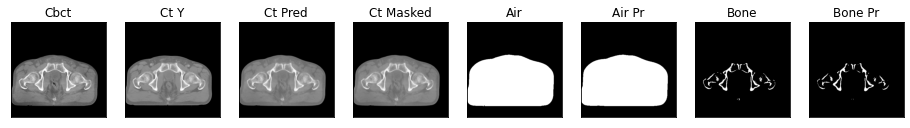

ssim score = 0.8900895118713379
psnr score = 27.272720336914062
snr score = 18.332021713256836
mae error = 0.01725327968597412
air dice score = 0.9977271107380177
bone dice score = 0.9029214850897304
contour dice score = 0.8838709592819214


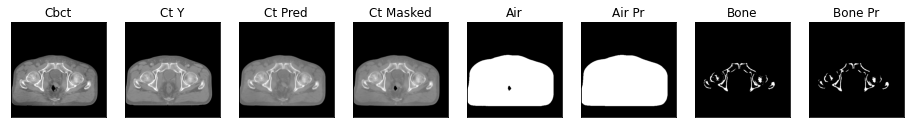

ssim score = 0.8867908120155334
psnr score = 27.326650619506836
snr score = 18.290283203125
mae error = 0.01720675826072693
air dice score = 0.9950969467350161
bone dice score = 0.9162397895622838
contour dice score = 0.888529896736145


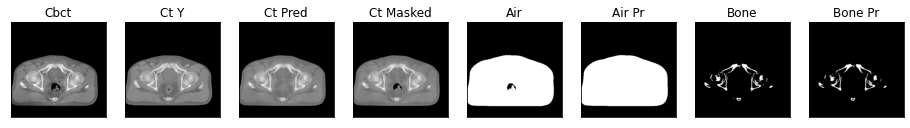

12it [00:29,  2.48s/it]

ssim score = 0.8904430866241455
psnr score = 27.44683837890625
snr score = 18.25071144104004
mae error = 0.0167629923671484
air dice score = 0.9932379984475459
bone dice score = 0.9160118735827482
contour dice score = 0.8743935227394104


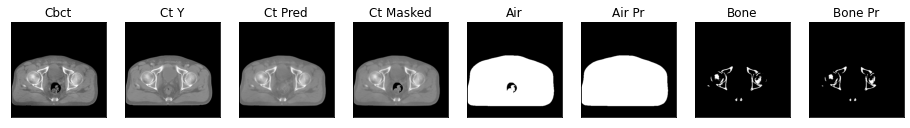

ssim score = 0.8908504247665405
psnr score = 27.555702209472656
snr score = 18.243148803710938
mae error = 0.016284385696053505
air dice score = 0.9898636389294407
bone dice score = 0.9108303249113568
contour dice score = 0.8401083946228027


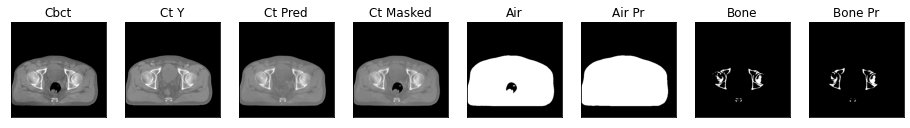

ssim score = 0.885461688041687
psnr score = 27.323713302612305
snr score = 17.966068267822266
mae error = 0.016724472865462303
air dice score = 0.9893167419713416
bone dice score = 0.9306176519302762
contour dice score = 0.8451928496360779


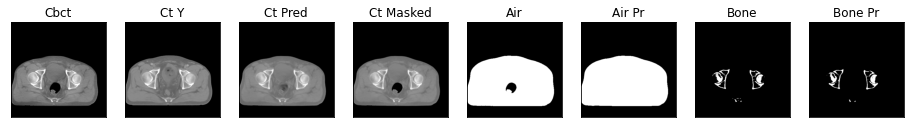

ssim score = 0.878878653049469
psnr score = 26.33832550048828
snr score = 16.987354278564453
mae error = 0.01850653998553753
air dice score = 0.9911680192757034
bone dice score = 0.9429508196730664
contour dice score = 0.8320610523223877


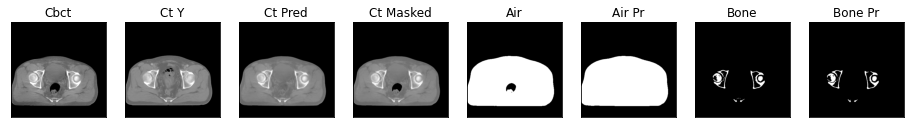

ssim score = 0.8783398270606995
psnr score = 25.41254234313965
snr score = 16.0916748046875
mae error = 0.020269673317670822
air dice score = 0.9931124637444396
bone dice score = 0.9528891599336349
contour dice score = 0.8493449687957764


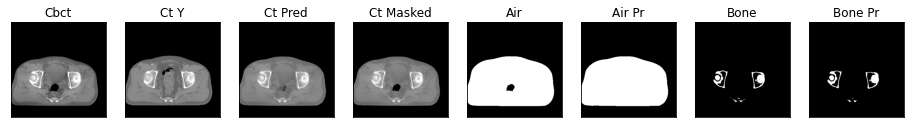

ssim score = 0.8839507699012756
psnr score = 25.281475067138672
snr score = 15.918020248413086
mae error = 0.01958591304719448
air dice score = 0.9964118948144537
bone dice score = 0.9469554835417541
contour dice score = 0.7910284399986267


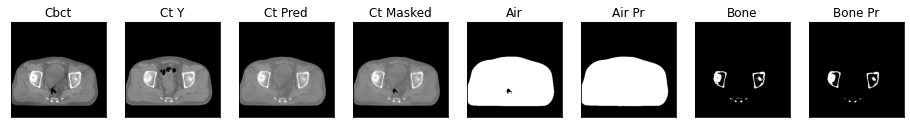

ssim score = 0.8860555291175842
psnr score = 25.119478225708008
snr score = 15.665821075439453
mae error = 0.019052555784583092
air dice score = 0.9976682294198607
bone dice score = 0.9445397369936241
contour dice score = 0.7829415202140808


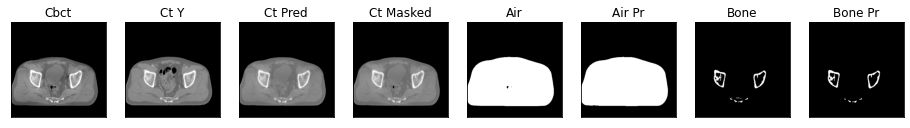

ssim score = 0.886987566947937
psnr score = 25.090412139892578
snr score = 15.571027755737305
mae error = 0.019106606021523476
air dice score = 0.9961259643522246
bone dice score = 0.950695825050682
contour dice score = 0.7877461910247803


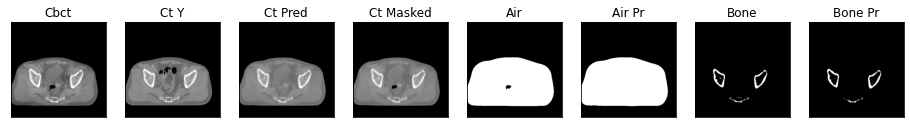

13it [00:32,  2.43s/it]

ssim score = 0.8866226673126221
psnr score = 25.202449798583984
snr score = 15.682764053344727
mae error = 0.01907658763229847
air dice score = 0.9956955749840923
bone dice score = 0.9526472130010022
contour dice score = 0.7648351788520813


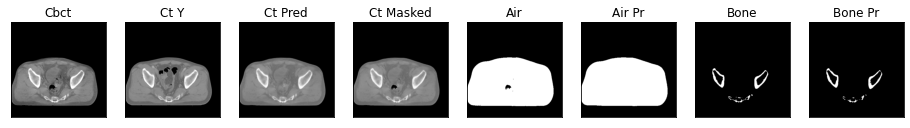

ssim score = 0.8825505971908569
psnr score = 25.196178436279297
snr score = 15.752657890319824
mae error = 0.019875576719641685
air dice score = 0.9948992517776657
bone dice score = 0.9476082004563268
contour dice score = 0.8052951097488403


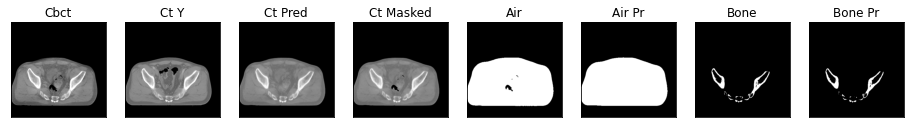

ssim score = 0.8873012661933899
psnr score = 25.298492431640625
snr score = 15.890554428100586
mae error = 0.01939433254301548
air dice score = 0.9955613754634234
bone dice score = 0.9412235105965451
contour dice score = 0.8202866315841675


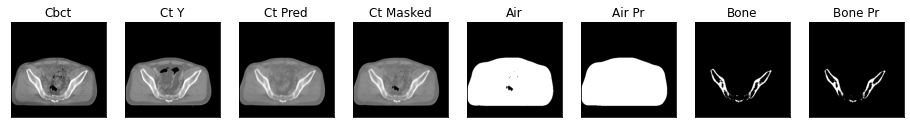

ssim score = 0.8877540826797485
psnr score = 25.383373260498047
snr score = 15.913735389709473
mae error = 0.019053049385547638
air dice score = 0.996875775706377
bone dice score = 0.9351720216102478
contour dice score = 0.8245711326599121


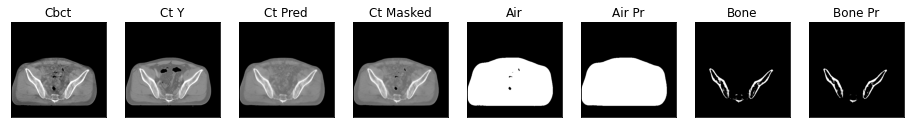

ssim score = 0.8829208612442017
psnr score = 24.998886108398438
snr score = 15.467988014221191
mae error = 0.01965942606329918
air dice score = 0.9971254197491457
bone dice score = 0.9289764249488365
contour dice score = 0.7964205741882324


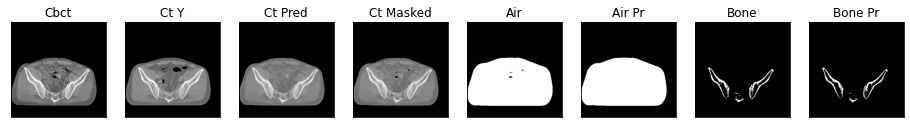

ssim score = 0.8075280785560608
psnr score = 22.280405044555664
snr score = 13.977709770202637
mae error = 0.03146703168749809
air dice score = 0.997252795944774
bone dice score = 0.971464806595705
contour dice score = 0.7752559185028076


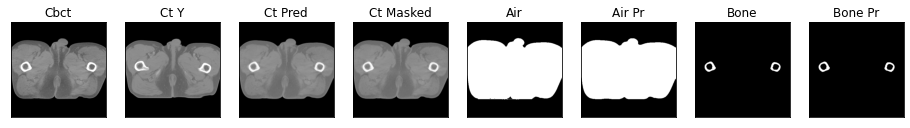

ssim score = 0.7984402179718018
psnr score = 21.905794143676758
snr score = 13.707391738891602
mae error = 0.03272935375571251
air dice score = 0.9978774319866897
bone dice score = 0.9736319818550146
contour dice score = 0.7452201247215271


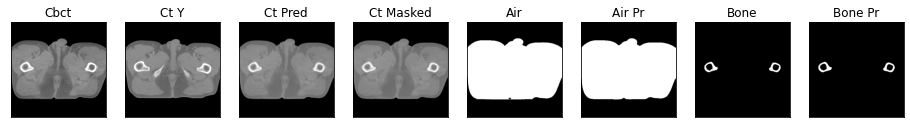

ssim score = 0.7931374311447144
psnr score = 21.67475128173828
snr score = 13.604307174682617
mae error = 0.03412038832902908
air dice score = 0.9981896263834136
bone dice score = 0.9528388278399076
contour dice score = 0.763310968875885


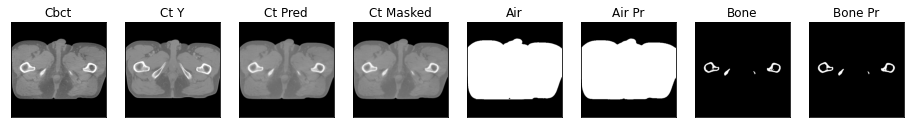

14it [00:34,  2.45s/it]

ssim score = 0.7848535180091858
psnr score = 21.393722534179688
snr score = 13.355566024780273
mae error = 0.0350545234978199
air dice score = 0.9982879413809838
bone dice score = 0.9564632711387382
contour dice score = 0.7695067524909973


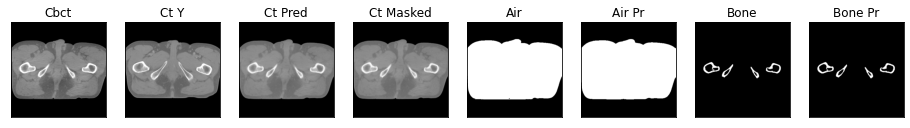

ssim score = 0.7766974568367004
psnr score = 21.290725708007812
snr score = 13.282809257507324
mae error = 0.03600743040442467
air dice score = 0.998338996287512
bone dice score = 0.9417971970331114
contour dice score = 0.7785778641700745


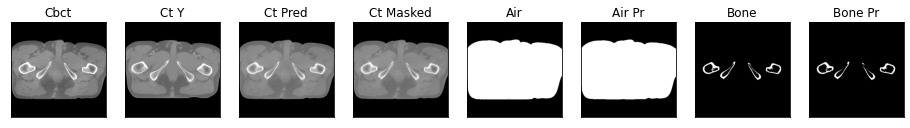

ssim score = 0.7694352865219116
psnr score = 21.15435791015625
snr score = 13.180855751037598
mae error = 0.03742006793618202
air dice score = 0.9983555594293859
bone dice score = 0.947434292866905
contour dice score = 0.7751239538192749


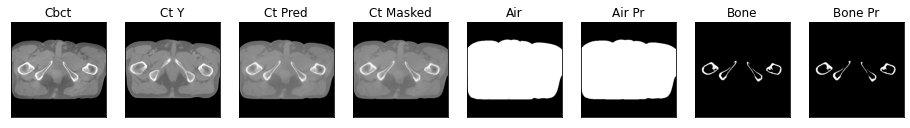

ssim score = 0.7609982490539551
psnr score = 20.883787155151367
snr score = 12.930594444274902
mae error = 0.03882961347699165
air dice score = 0.9983618608797338
bone dice score = 0.9467954823792789
contour dice score = 0.7883145809173584


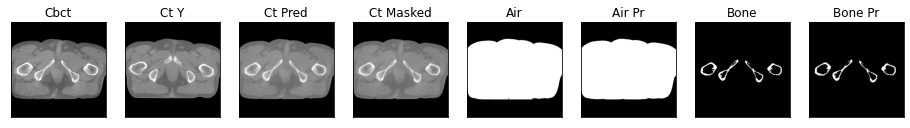

ssim score = 0.761256992816925
psnr score = 20.978002548217773
snr score = 13.063882827758789
mae error = 0.03816864639520645
air dice score = 0.997722701315517
bone dice score = 0.940842019765252
contour dice score = 0.7501117587089539


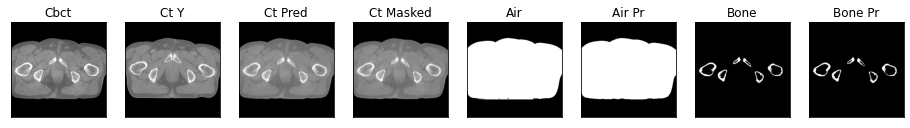

ssim score = 0.7599812746047974
psnr score = 21.177791595458984
snr score = 13.31235122680664
mae error = 0.037575263530015945
air dice score = 0.9971212874434968
bone dice score = 0.9502487562195568
contour dice score = 0.7359307408332825


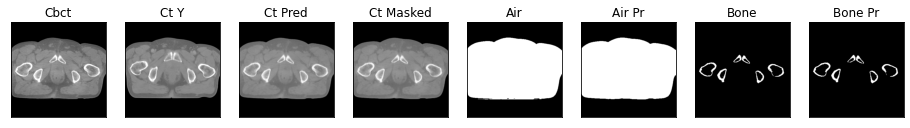

ssim score = 0.7557810544967651
psnr score = 21.042510986328125
snr score = 13.19968318939209
mae error = 0.03912796452641487
air dice score = 0.9970587725431522
bone dice score = 0.9496348526825783
contour dice score = 0.7152542471885681


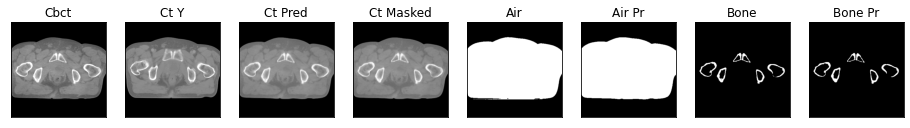

ssim score = 0.7434629201889038
psnr score = 20.95884132385254
snr score = 13.158792495727539
mae error = 0.0404462032020092
air dice score = 0.9978033129039524
bone dice score = 0.9463000118028289
contour dice score = 0.7799915075302124


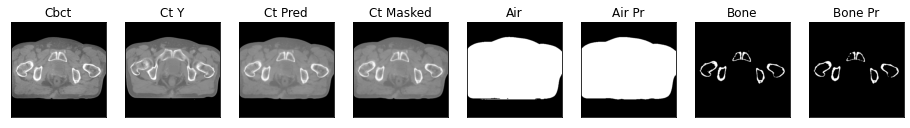

15it [00:37,  2.48s/it]

ssim score = 0.7429205179214478
psnr score = 20.944801330566406
snr score = 13.203088760375977
mae error = 0.04080243408679962
air dice score = 0.9979889911630537
bone dice score = 0.9446835987952574
contour dice score = 0.7611738443374634


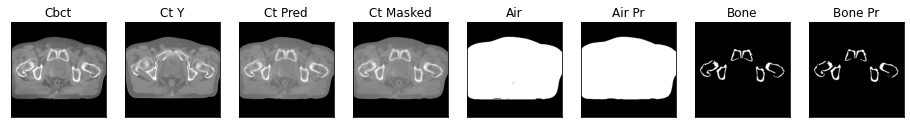

ssim score = 0.7357220649719238
psnr score = 20.633670806884766
snr score = 12.8165864944458
mae error = 0.043264150619506836
air dice score = 0.9985304585428586
bone dice score = 0.9402561846099515
contour dice score = 0.8265213370323181


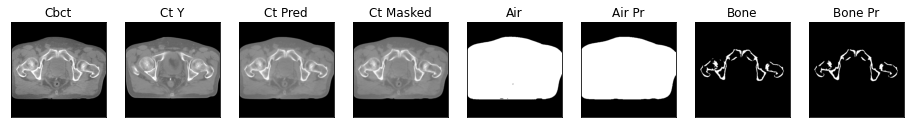

ssim score = 0.73786860704422
psnr score = 20.418607711791992
snr score = 12.494306564331055
mae error = 0.04471911862492561
air dice score = 0.9987145939494109
bone dice score = 0.9304205562512711
contour dice score = 0.8311333656311035


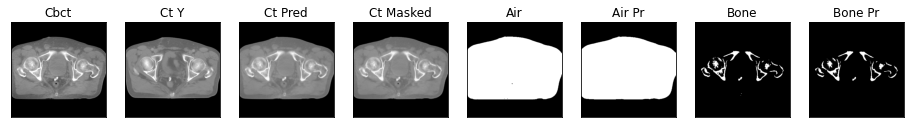

ssim score = 0.7500060796737671
psnr score = 20.534170150756836
snr score = 12.486781120300293
mae error = 0.04446074739098549
air dice score = 0.9988566700947419
bone dice score = 0.9015533980592082
contour dice score = 0.8469620943069458


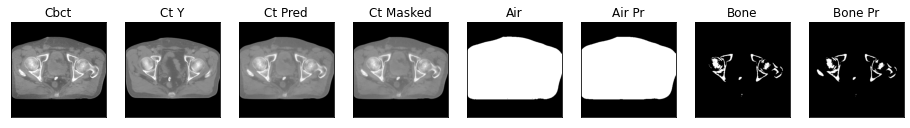

ssim score = 0.7552337050437927
psnr score = 20.74346923828125
snr score = 12.583651542663574
mae error = 0.043225571513175964
air dice score = 0.99911890214055
bone dice score = 0.9242963113512418
contour dice score = 0.8795235753059387


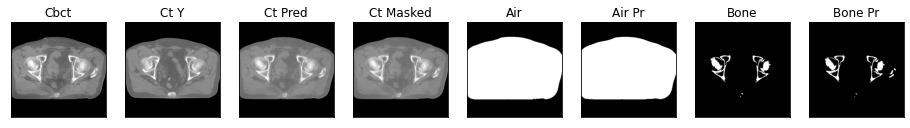

ssim score = 0.7515133619308472
psnr score = 21.000049591064453
snr score = 12.789583206176758
mae error = 0.04076528921723366
air dice score = 0.9989606790230389
bone dice score = 0.9493284493289649
contour dice score = 0.8624022006988525


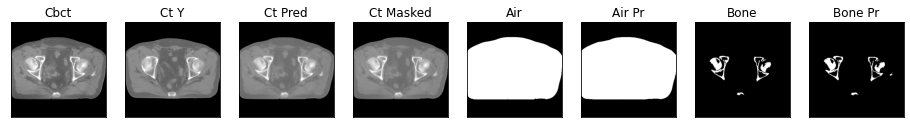

ssim score = 0.7504676580429077
psnr score = 20.848495483398438
snr score = 12.670184135437012
mae error = 0.041499506682157516
air dice score = 0.9991539665063457
bone dice score = 0.9471169508095655
contour dice score = 0.8843663334846497


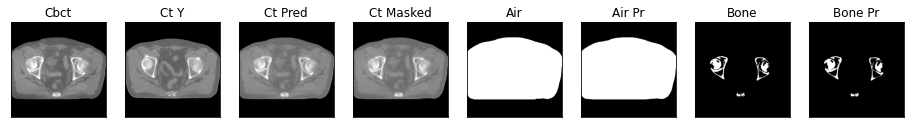

ssim score = 0.7485123872756958
psnr score = 20.609405517578125
snr score = 12.444572448730469
mae error = 0.042861614376306534
air dice score = 0.9990633054264293
bone dice score = 0.9485285496547247
contour dice score = 0.8647140860557556


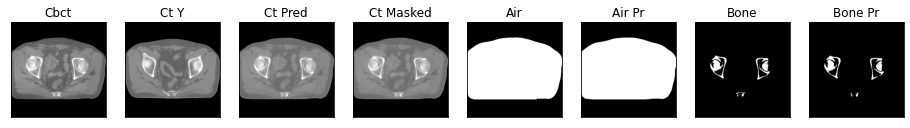

16it [00:39,  2.43s/it]

ssim score = 0.7464789152145386
psnr score = 20.20479965209961
snr score = 11.89847469329834
mae error = 0.0450231097638607
air dice score = 0.9990119559180338
bone dice score = 0.9584057467273965
contour dice score = 0.8722015023231506


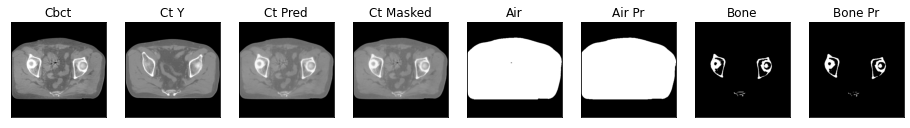

ssim score = 0.7556520700454712
psnr score = 20.28057861328125
snr score = 11.914944648742676
mae error = 0.04433649405837059
air dice score = 0.9990536815315083
bone dice score = 0.9551587842448527
contour dice score = 0.866572380065918


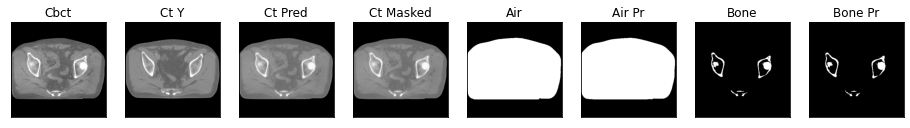

ssim score = 0.7547004818916321
psnr score = 20.616758346557617
snr score = 12.276771545410156
mae error = 0.04163350537419319
air dice score = 0.9990432317505321
bone dice score = 0.9349857006685417
contour dice score = 0.8650943636894226


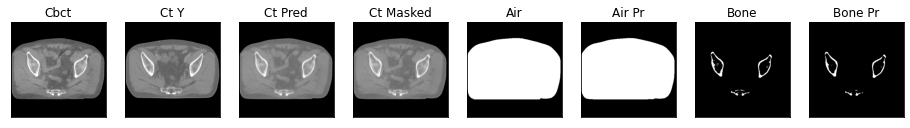

ssim score = 0.7498921155929565
psnr score = 20.636089324951172
snr score = 12.368917465209961
mae error = 0.041306015104055405
air dice score = 0.9986586263384069
bone dice score = 0.9457884513518314
contour dice score = 0.8394712209701538


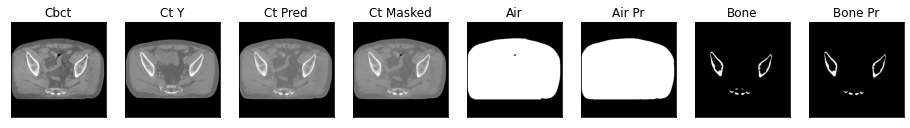

ssim score = 0.7441100478172302
psnr score = 20.490177154541016
snr score = 12.35223388671875
mae error = 0.04210017994046211
air dice score = 0.9981673501793858
bone dice score = 0.9453471196463918
contour dice score = 0.8407037854194641


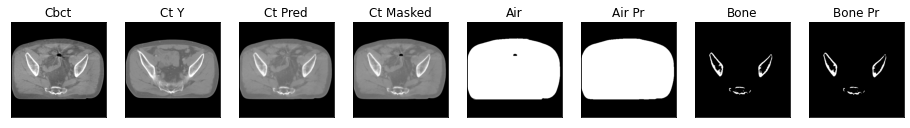

ssim score = 0.7379606366157532
psnr score = 20.40968132019043
snr score = 12.305700302124023
mae error = 0.04257616773247719
air dice score = 0.9975875850646325
bone dice score = 0.943023777479542
contour dice score = 0.8199234008789062


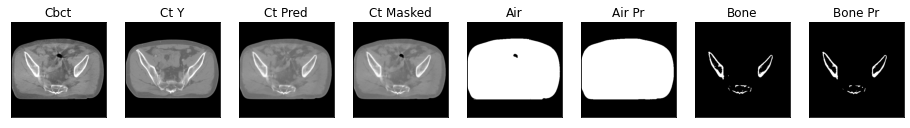

ssim score = 0.7255725860595703
psnr score = 20.20602798461914
snr score = 12.072256088256836
mae error = 0.04413384199142456
air dice score = 0.9983860088649075
bone dice score = 0.941247728650015
contour dice score = 0.8278177380561829


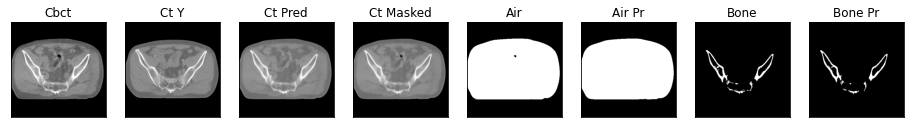

ssim score = 0.7251946926116943
psnr score = 20.29791831970215
snr score = 12.10076904296875
mae error = 0.04346861317753792
air dice score = 0.9986640633028474
bone dice score = 0.9295336787573895
contour dice score = 0.8169556856155396


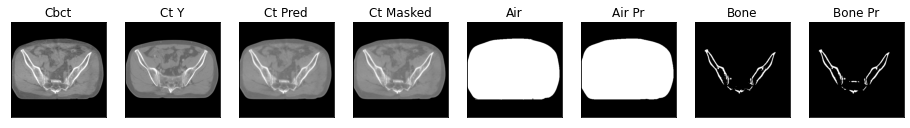

17it [00:42,  2.46s/it]

ssim score = 0.8553248643875122
psnr score = 24.405075073242188
snr score = 15.882464408874512
mae error = 0.02317304164171219
air dice score = 0.9985110559650369
bone dice score = 0.9270922681052923
contour dice score = 0.8514456748962402


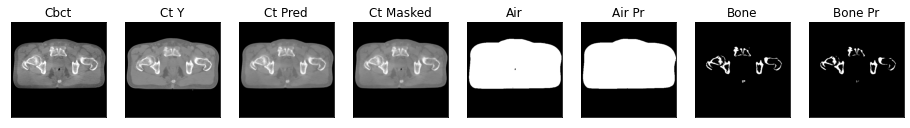

ssim score = 0.8597144484519958
psnr score = 24.741920471191406
snr score = 16.25932502746582
mae error = 0.021883035078644753
air dice score = 0.9980929483611984
bone dice score = 0.9237029501535643
contour dice score = 0.8497983813285828


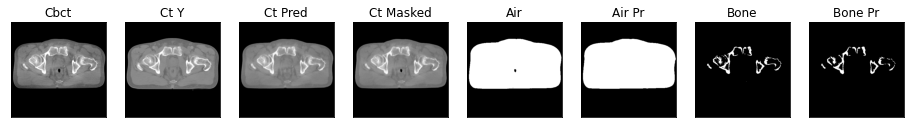

ssim score = 0.8585608005523682
psnr score = 24.901126861572266
snr score = 16.42631721496582
mae error = 0.021927552297711372
air dice score = 0.9987520613272728
bone dice score = 0.9096998928200737
contour dice score = 0.8831562995910645


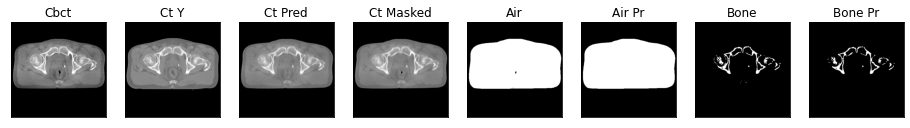

ssim score = 0.8641910552978516
psnr score = 25.053319931030273
snr score = 16.520092010498047
mae error = 0.02102021686732769
air dice score = 0.9979369158008432
bone dice score = 0.9210856999255959
contour dice score = 0.8519269824028015


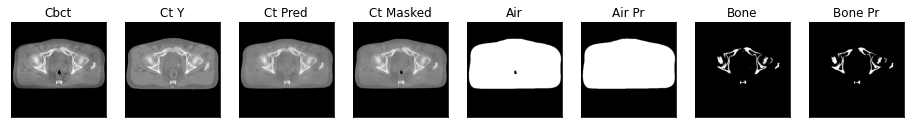

ssim score = 0.8700919151306152
psnr score = 25.15243148803711
snr score = 16.463577270507812
mae error = 0.020077789202332497
air dice score = 0.9978411730871241
bone dice score = 0.9167811879688994
contour dice score = 0.8600509166717529


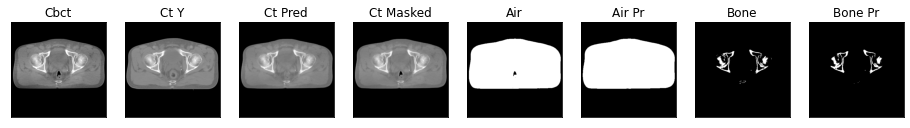

ssim score = 0.8729811310768127
psnr score = 25.24799156188965
snr score = 16.538333892822266
mae error = 0.01975349336862564
air dice score = 0.9979850036329875
bone dice score = 0.9281736398696534
contour dice score = 0.8488253355026245


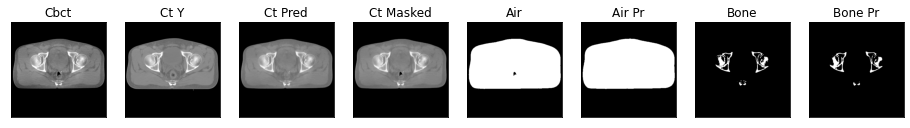

ssim score = 0.8699672222137451
psnr score = 25.282466888427734
snr score = 16.557180404663086
mae error = 0.019703906029462814
air dice score = 0.9981740169373093
bone dice score = 0.9326047358843688
contour dice score = 0.849820613861084


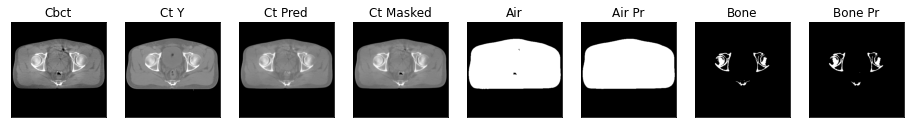

ssim score = 0.8638587594032288
psnr score = 24.70583724975586
snr score = 15.989914894104004
mae error = 0.020914580672979355
air dice score = 0.997488024742581
bone dice score = 0.9330896823174994
contour dice score = 0.8292180895805359


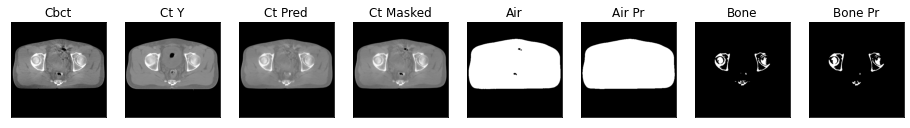

18it [00:44,  2.47s/it]

ssim score = 0.8600205779075623
psnr score = 24.67768669128418
snr score = 16.01754379272461
mae error = 0.02139098197221756
air dice score = 0.998208711557213
bone dice score = 0.9477399212712401
contour dice score = 0.8316115736961365


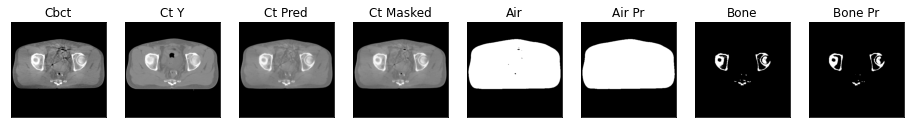

ssim score = 0.8583548069000244
psnr score = 23.91437530517578
snr score = 15.232303619384766
mae error = 0.022690201178193092
air dice score = 0.9973899452192011
bone dice score = 0.9506826414049779
contour dice score = 0.8354955911636353


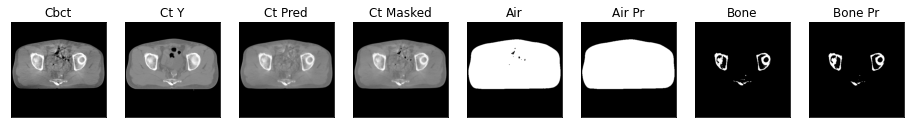

ssim score = 0.8583840131759644
psnr score = 23.426969528198242
snr score = 14.674124717712402
mae error = 0.022939302027225494
air dice score = 0.9971764956581983
bone dice score = 0.9314939645723234
contour dice score = 0.8452318906784058


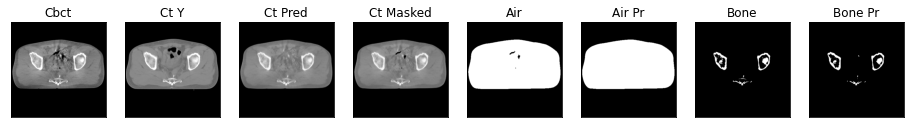

ssim score = 0.8612155318260193
psnr score = 23.756534576416016
snr score = 14.959797859191895
mae error = 0.02219614014029503
air dice score = 0.9981779786998862
bone dice score = 0.9388573337798387
contour dice score = 0.8416100144386292


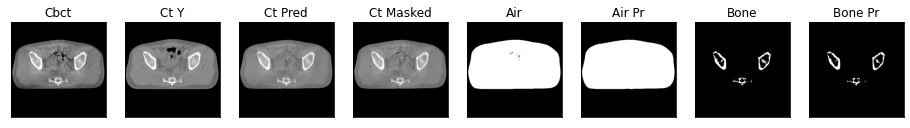

ssim score = 0.8636870384216309
psnr score = 24.225582122802734
snr score = 15.42774772644043
mae error = 0.02131497487425804
air dice score = 0.9975292398779173
bone dice score = 0.9404358353520511
contour dice score = 0.825630247592926


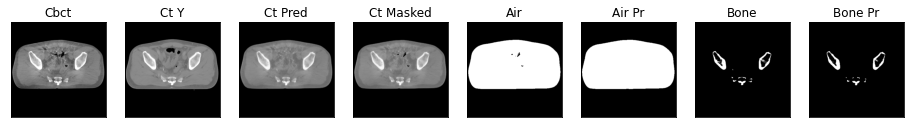

ssim score = 0.8621413707733154
psnr score = 24.710540771484375
snr score = 15.926061630249023
mae error = 0.02088840678334236
air dice score = 0.9967911318553117
bone dice score = 0.9479679802963675
contour dice score = 0.8414955139160156


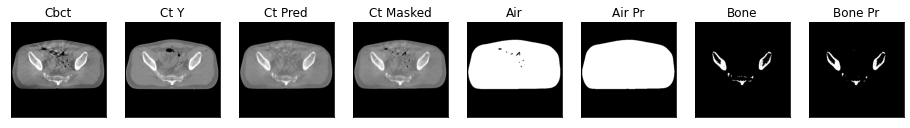

ssim score = 0.8613121509552002
psnr score = 24.955482482910156
snr score = 16.226207733154297
mae error = 0.021058393642306328
air dice score = 0.9954868224457453
bone dice score = 0.9536694320363284
contour dice score = 0.8257655501365662


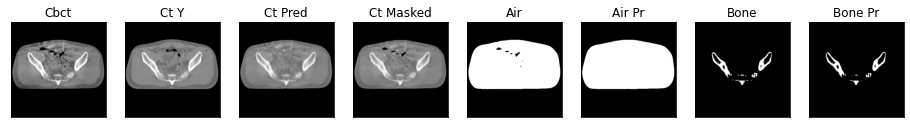

ssim score = 0.8627729415893555
psnr score = 24.314739227294922
snr score = 15.604835510253906
mae error = 0.021615801379084587
air dice score = 0.9957409379195441
bone dice score = 0.9359243697487405
contour dice score = 0.839767336845398


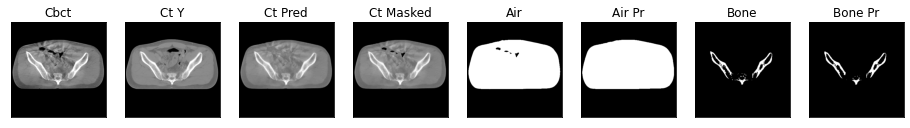

19it [00:46,  2.42s/it]

ssim score = 0.8660773038864136
psnr score = 23.759260177612305
snr score = 14.994617462158203
mae error = 0.02214505709707737
air dice score = 0.9965108918839667
bone dice score = 0.933447831688372
contour dice score = 0.8101802468299866


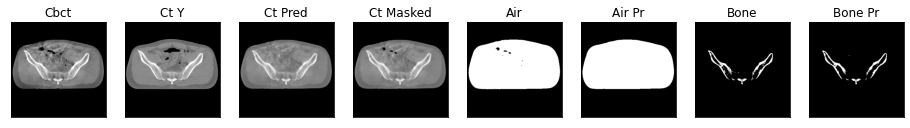

ssim score = 0.865167498588562
psnr score = 23.59911346435547
snr score = 14.798117637634277
mae error = 0.02249748259782791
air dice score = 0.997712837472378
bone dice score = 0.9266531908760229
contour dice score = 0.8078765273094177


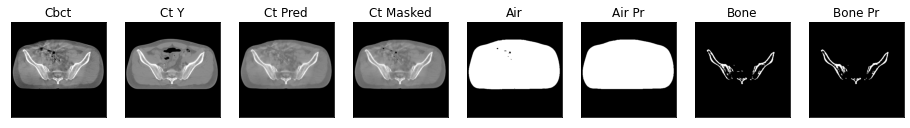

ssim score = 0.868063747882843
psnr score = 23.660757064819336
snr score = 14.859832763671875
mae error = 0.022106172516942024
air dice score = 0.9974710172388478
bone dice score = 0.9250552019752558
contour dice score = 0.759358286857605


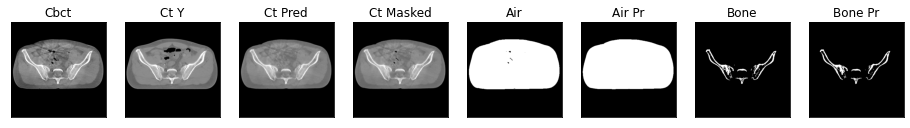

ssim score = 0.8692552447319031
psnr score = 24.27872657775879
snr score = 15.476380348205566
mae error = 0.02149059623479843
air dice score = 0.9976155823243446
bone dice score = 0.9261816250673635
contour dice score = 0.7903226017951965


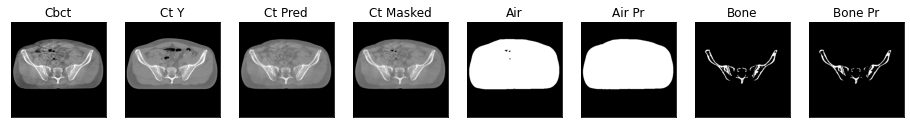

ssim score = 0.8619807958602905
psnr score = 24.028194427490234
snr score = 15.230888366699219
mae error = 0.02208825573325157
air dice score = 0.9969426079399099
bone dice score = 0.9228308676539674
contour dice score = 0.7967567443847656


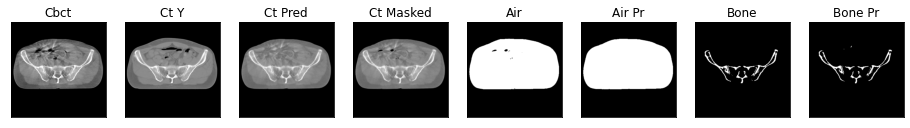

ssim score = 0.8577628135681152
psnr score = 23.750524520874023
snr score = 14.935943603515625
mae error = 0.02280392497777939
air dice score = 0.9958355063946416
bone dice score = 0.911611785096499
contour dice score = 0.8134855628013611


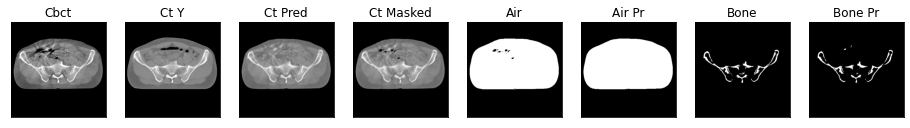

ssim score = 0.8514693379402161
psnr score = 23.225933074951172
snr score = 14.392730712890625
mae error = 0.02415016107261181
air dice score = 0.9951809299165096
bone dice score = 0.9177962939943067
contour dice score = 0.8361643552780151


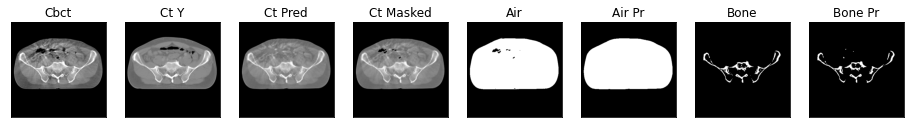

ssim score = 0.8418055176734924
psnr score = 22.76154327392578
snr score = 13.882400512695312
mae error = 0.025711068883538246
air dice score = 0.9944916748286037
bone dice score = 0.910334717811992
contour dice score = 0.8048511743545532


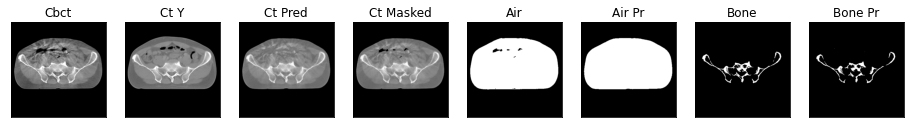

20it [00:49,  2.44s/it]

ssim score = 0.8348692655563354
psnr score = 22.89773941040039
snr score = 13.964797973632812
mae error = 0.02586553618311882
air dice score = 0.9938511377754062
bone dice score = 0.9148783977120304
contour dice score = 0.8031059503555298


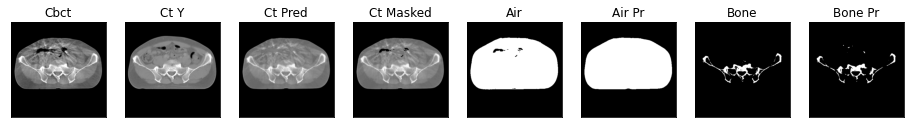

ssim score = 0.8273088335990906
psnr score = 22.567148208618164
snr score = 13.6646728515625
mae error = 0.02728521265089512
air dice score = 0.9928025759202027
bone dice score = 0.9296983758708851
contour dice score = 0.770856499671936


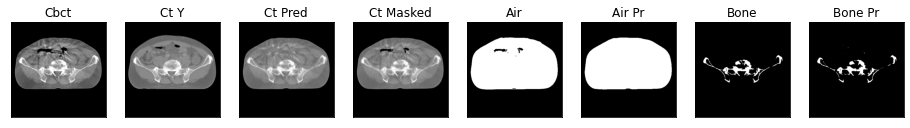

ssim score = 0.8191187977790833
psnr score = 22.009218215942383
snr score = 13.051514625549316
mae error = 0.02854367159307003
air dice score = 0.992862229959648
bone dice score = 0.9205153135644079
contour dice score = 0.7222222089767456


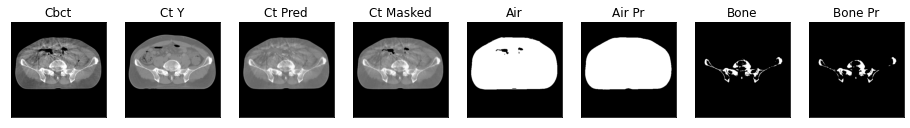

ssim score = 0.8251007199287415
psnr score = 22.62175750732422
snr score = 13.516523361206055
mae error = 0.0268420223146677
air dice score = 0.993634309722943
bone dice score = 0.9299492385795691
contour dice score = 0.7202680110931396


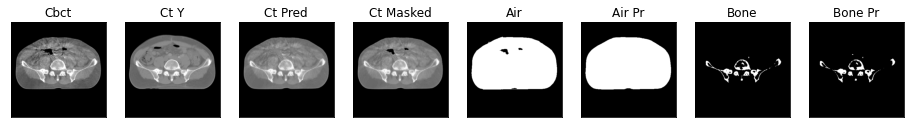

ssim score = 0.8790162801742554
psnr score = 26.330461502075195
snr score = 16.71137237548828
mae error = 0.02032201550900936
air dice score = 0.9963216594549597
bone dice score = 0.9585406301835672
contour dice score = 0.6989820599555969


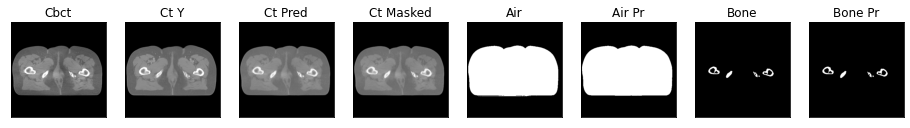

ssim score = 0.8797120451927185
psnr score = 26.496902465820312
snr score = 16.99882698059082
mae error = 0.02025681361556053
air dice score = 0.9967191024401699
bone dice score = 0.9582159624422953
contour dice score = 0.7377777695655823


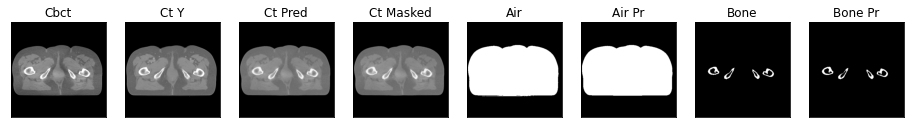

ssim score = 0.8767042756080627
psnr score = 26.484169006347656
snr score = 17.069007873535156
mae error = 0.02052009105682373
air dice score = 0.9967836767959041
bone dice score = 0.9447043811155954
contour dice score = 0.7365853786468506


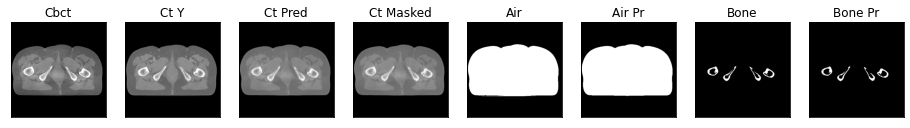

ssim score = 0.8745261430740356
psnr score = 26.38677978515625
snr score = 17.035066604614258
mae error = 0.020933616906404495
air dice score = 0.9967920634345945
bone dice score = 0.9473485563323769
contour dice score = 0.7196489572525024


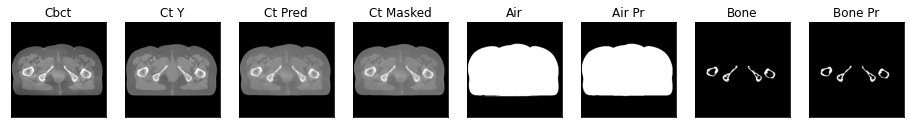

21it [00:51,  2.47s/it]

ssim score = 0.8748200535774231
psnr score = 26.236703872680664
snr score = 16.913450241088867
mae error = 0.02120278589427471
air dice score = 0.9969330244708587
bone dice score = 0.9522111269623358
contour dice score = 0.7131630778312683


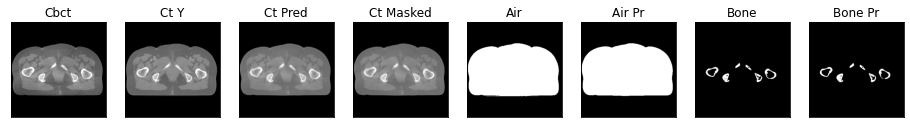

ssim score = 0.8764461278915405
psnr score = 26.148595809936523
snr score = 16.848299026489258
mae error = 0.021266566589474678
air dice score = 0.9966963443863069
bone dice score = 0.948713131693618
contour dice score = 0.7172011733055115


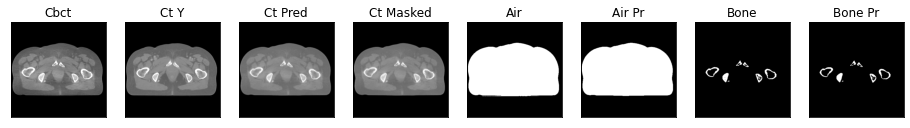

ssim score = 0.8743429780006409
psnr score = 26.085975646972656
snr score = 16.81700325012207
mae error = 0.021299436688423157
air dice score = 0.9966471622931423
bone dice score = 0.946845686960698
contour dice score = 0.6940154433250427


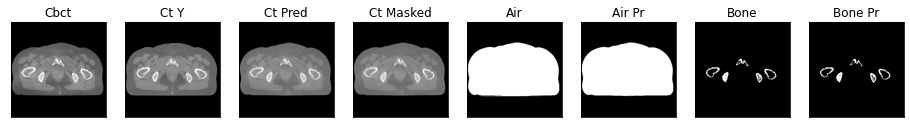

ssim score = 0.874269425868988
psnr score = 26.03945541381836
snr score = 16.81884765625
mae error = 0.021617742255330086
air dice score = 0.9966730242496403
bone dice score = 0.9368325791866636
contour dice score = 0.6954887509346008


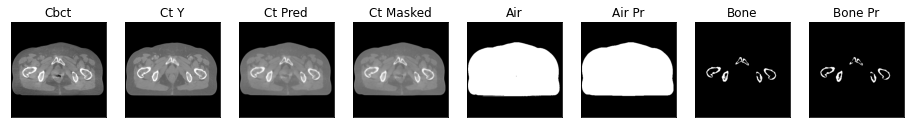

ssim score = 0.8759459853172302
psnr score = 26.083663940429688
snr score = 16.905803680419922
mae error = 0.021382782608270645
air dice score = 0.9959291325038732
bone dice score = 0.9431279620862707
contour dice score = 0.7024952173233032


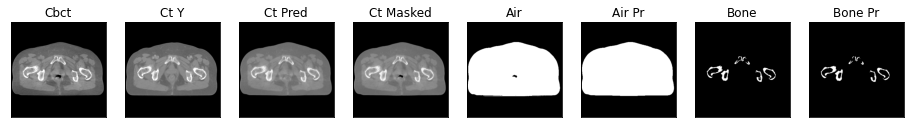

ssim score = 0.8747158050537109
psnr score = 26.250391006469727
snr score = 17.160228729248047
mae error = 0.021438010036945343
air dice score = 0.9952569962887104
bone dice score = 0.9351295943778719
contour dice score = 0.6809902191162109


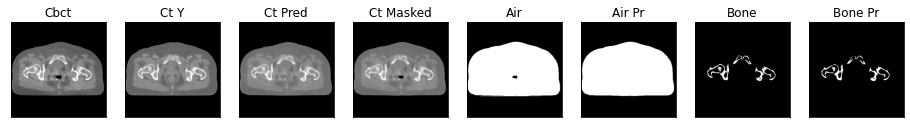

ssim score = 0.8752662539482117
psnr score = 26.58163833618164
snr score = 17.60474967956543
mae error = 0.021061446517705917
air dice score = 0.995973154362419
bone dice score = 0.9405666063901076
contour dice score = 0.6694253087043762


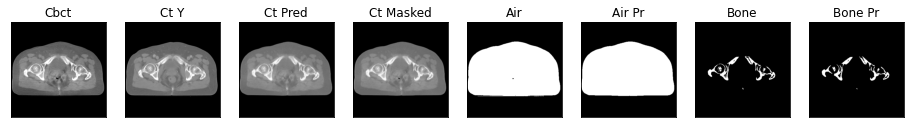

ssim score = 0.8800541162490845
psnr score = 26.896486282348633
snr score = 17.791046142578125
mae error = 0.020302683115005493
air dice score = 0.9942819614085976
bone dice score = 0.9247274006344578
contour dice score = 0.6629732251167297


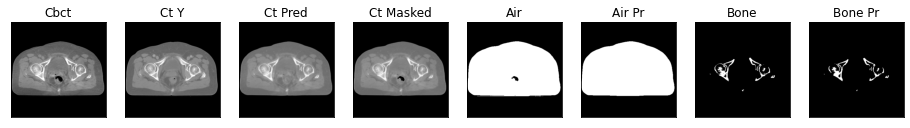

22it [00:54,  2.43s/it]

ssim score = 0.8830967545509338
psnr score = 27.295934677124023
snr score = 18.08107566833496
mae error = 0.0195830799639225
air dice score = 0.993439349639882
bone dice score = 0.9137621987669038
contour dice score = 0.6542230248451233


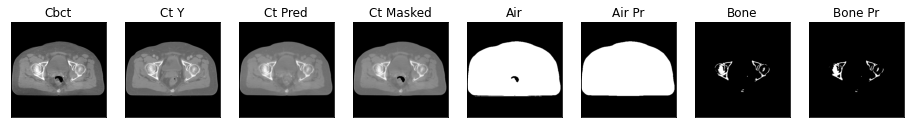

ssim score = 0.8848524689674377
psnr score = 27.158239364624023
snr score = 17.916250228881836
mae error = 0.02040441334247589
air dice score = 0.9937433345183123
bone dice score = 0.9324679880734525
contour dice score = 0.6550777554512024


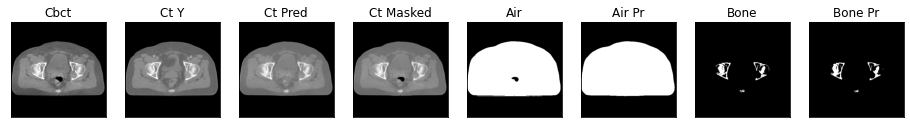

ssim score = 0.8855941891670227
psnr score = 26.815059661865234
snr score = 17.565067291259766
mae error = 0.021473167464137077
air dice score = 0.9958199175281055
bone dice score = 0.9443603967062639
contour dice score = 0.6859273314476013


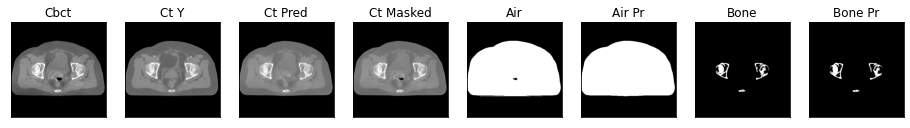

ssim score = 0.8837948441505432
psnr score = 26.934968948364258
snr score = 17.719207763671875
mae error = 0.02104792930185795
air dice score = 0.9965950172351004
bone dice score = 0.9512658227855812
contour dice score = 0.6716768145561218


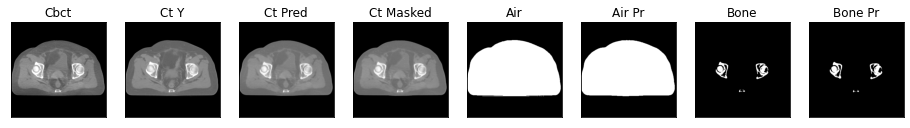

ssim score = 0.8780940771102905
psnr score = 26.33592987060547
snr score = 17.17165756225586
mae error = 0.02181602269411087
air dice score = 0.9971691485884018
bone dice score = 0.9625769777362612
contour dice score = 0.7111965417861938


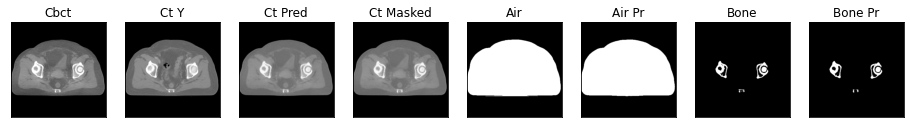

ssim score = 0.8666168451309204
psnr score = 25.403383255004883
snr score = 16.276668548583984
mae error = 0.02307805046439171
air dice score = 0.9974963272569282
bone dice score = 0.9599860821162146
contour dice score = 0.7450602650642395


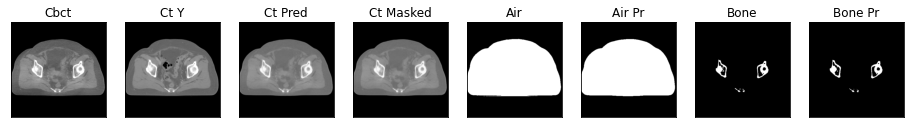

ssim score = 0.8517430424690247
psnr score = 23.969125747680664
snr score = 14.769974708557129
mae error = 0.025738190859556198
air dice score = 0.9969631889252172
bone dice score = 0.9497181510721597
contour dice score = 0.7252318263053894


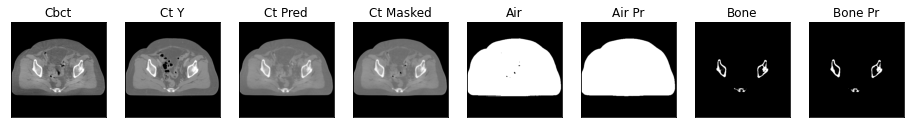

ssim score = 0.8449722528457642
psnr score = 23.808563232421875
snr score = 14.591418266296387
mae error = 0.026820655912160873
air dice score = 0.9955873567588147
bone dice score = 0.9584751531663609
contour dice score = 0.7566502690315247


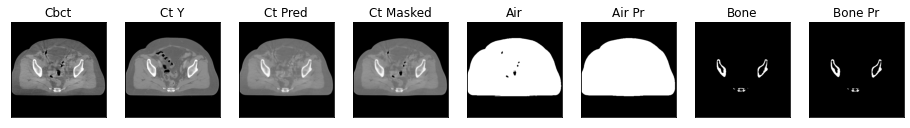

23it [00:56,  2.47s/it]

ssim score = 0.8421182632446289
psnr score = 24.28644561767578
snr score = 15.134218215942383
mae error = 0.0262118149548769
air dice score = 0.9965982735902355
bone dice score = 0.9500657030234326
contour dice score = 0.7761341333389282


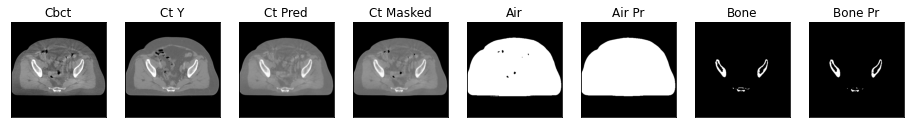

ssim score = 0.8421636819839478
psnr score = 24.11227798461914
snr score = 15.015143394470215
mae error = 0.026828406378626823
air dice score = 0.9967690145161204
bone dice score = 0.9580615097864295
contour dice score = 0.7739691734313965


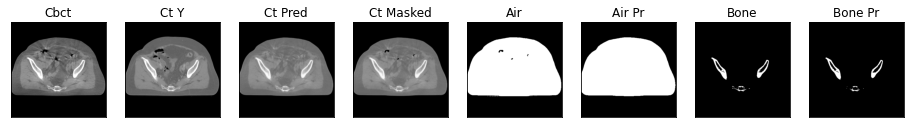

ssim score = 0.8395837545394897
psnr score = 23.824237823486328
snr score = 14.791534423828125
mae error = 0.02775607816874981
air dice score = 0.9968320177407027
bone dice score = 0.9578865578872123
contour dice score = 0.7409224510192871


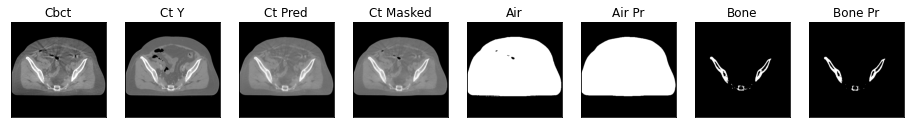

ssim score = 0.8391329646110535
psnr score = 23.889232635498047
snr score = 14.9293851852417
mae error = 0.027761539444327354
air dice score = 0.9966883082883943
bone dice score = 0.9403135337273074
contour dice score = 0.7506148815155029


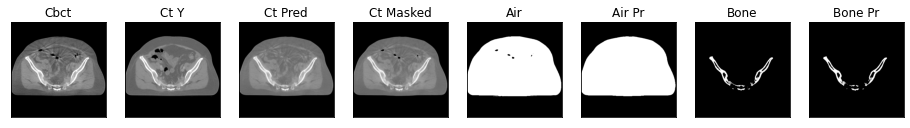

ssim score = 0.8403908014297485
psnr score = 23.983591079711914
snr score = 15.019454002380371
mae error = 0.02801508642733097
air dice score = 0.9965674092050557
bone dice score = 0.935806831567494
contour dice score = 0.7384315729141235


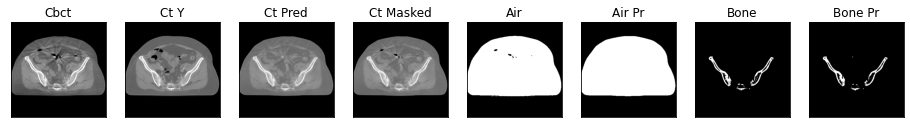

ssim score = 0.8388760685920715
psnr score = 23.672321319580078
snr score = 14.686006546020508
mae error = 0.028858641162514687
air dice score = 0.997130725681937
bone dice score = 0.9397969397978007
contour dice score = 0.7335271239280701


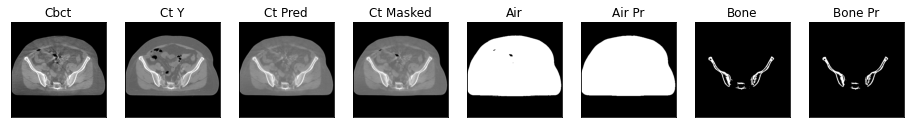

ssim score = 0.8436964750289917
psnr score = 24.179277420043945
snr score = 15.204599380493164
mae error = 0.02799828164279461
air dice score = 0.9976007861253987
bone dice score = 0.9375470278414214
contour dice score = 0.7291967272758484


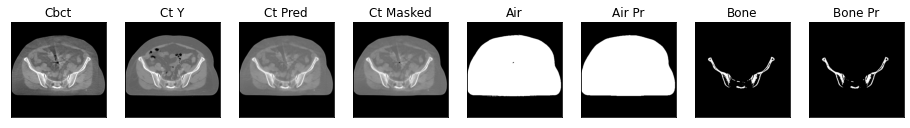

24it [00:59,  2.47s/it]


In [34]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [35]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [36]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [37]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
# unmasked
eval_epoch(model, discriminator, testloader, device)

24it [00:06,  3.89it/s]


(0.8506075690189997,
 24.0810120900472,
 15.095583200454712,
 0.02509305893909186,
 0.9968409425808159,
 0.9445070359801386,
 0.7810336660340195,
 0.375)

In [38]:
# import torchvision.models as models
# models.vgg16(pretrained=True)